# Decision Analysis Project 2

- Mateusz Tabaszewski 151945
- Bartłomiej Pukacki 151942

This is our notebook dedicated to the second project from decision analysis classes, in this notebook we set out to implement our own versions of UTA and AHP methods used for multi-criteria decision analysis (MCDA).

Sections present in this notebook:
* Imports - imports used for the notebook
* Utilities - general functions and classes which can be used outside the implemented methods
* Data - showcase of the constructed dataset
* UTA - implementation of UTA method
* AHP - implementation of AHP method
* Comparison - comparison of methods including PROMETHEE II results

## Imports

In [2]:
!pip install pulp

In [3]:
import pulp

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

## Utilities

In [4]:
def get_pairwise_comparisons(data, column, boundaries, cost=False):
    """
    Returns pairwise comparisons based on specified boundaries

    Parameters:
        - data: dataframe with data
        - column: name of the column for which the comparison will be performed
        - boundaries: list of 8 boundaries of differences for which the Saaty's scale preference intensity increases
            e.g. with list [1,2,3,4,5,6,10,12] Saaty's preference of 9 applied for difference in values >12,
            the preference of 8 is applied for differences in interval (10, 12], 1 for [0, 1] etc.
        - cost: set to true to compare values of cost type criteria. Default = False
    """
    comparisons = []
    # Apply comparison based on boundaries
    for i in range(len(data)):
        row = []
        for j in range(len(data)):
            if data.at[j, column] != 0:
                diff = data.at[i, column] - data.at[j, column]
                if cost:
                    diff *= -1

                if diff < 0:
                    row.append("L")
                elif diff <= boundaries[0]:
                    row.append(1)
                elif diff <= boundaries[1]:
                    row.append(2)
                elif diff <= boundaries[2]:
                    row.append(3)
                elif diff <= boundaries[3]:
                    row.append(4)
                elif diff <= boundaries[4]:
                    row.append(5)
                elif diff <= boundaries[5]:
                    row.append(6)
                elif diff <= boundaries[6]:
                    row.append(7)
                elif diff <= boundaries[7]:
                    row.append(8)
                else:
                    row.append(9)

            else:
                row.append(None)
        comparisons.append(row)

    # Create inverse values
    for i in range(len(data)):
        for j in range(len(data)):
            if comparisons[i][j] == "L":
                comparisons[i][j] = round(1/comparisons[j][i], 2)

    df_comparisons = pd.DataFrame(comparisons, columns=data['id'], index=data['id'])
    return df_comparisons

def get_pairwise_proportions(data, column, cost=False):
    """
    Returns pairwise comparisons based on value proportions

    Parameters:
        - data: dataframe with data
        - column: name of the column for which the comparison will be performed
        - cost: set to true to compare values of cost type criteria. Default = False
    """
    proportions = []
    for i in range(len(data)):
        row = []
        for j in range(len(data)):
            if data.at[j, column] != 0:
                if cost:
                    row.append(data.at[j, column] / data.at[i, column])
                else:
                    row.append(data.at[i, column] / data.at[j, column])
            else:
                row.append(None)
        proportions.append(row)

    df_proportions = pd.DataFrame(proportions, columns=data['id'], index=data['id'])
    return df_proportions

def get_preference_matrix(ranking, reference_items):
    """
    Returns a preference matrix using alphabetic items order as reference
    
    Parameters:
        - ranking: list of string or list items in quality descending order
        - reference_items: list of reference item order for uniform matrices
    """
    n = len(reference_items)
    preference_matrix = np.zeros((n,n))

    item_positions = {}    
    pos = 0
    for position in ranking:
        if isinstance(position, list):
            for item in position:
                item_positions[item] = pos
        else:
            item_positions[position] = pos

        pos += 1

    for i, item1 in enumerate(reference_items):
        for j, item2 in enumerate(reference_items):
            if item_positions[item1] < item_positions[item2]:
                preference_matrix[i,j] = 1

    return preference_matrix

def get_kendall_distance(pref_matrix1, pref_matrix2):
    return 1/2 * np.sum(np.abs(pref_matrix1-pref_matrix2))

def get_kendall_tau(ranking1, ranking2):
    """
    Returns kendalls tau distance between two rankings
    
    Parameters:
        - ranking1: list of list or string items in quality descending order
        - ranking2: list of the same set of items in quality descending order
    """
    items1 = []
    for x in ranking1:
        if isinstance(x, list):
            for y in x:
                items1.append(y)
        else:
            items1.append(x)
    
    items2 = []
    for x in ranking2:
        if isinstance(x, list):
            for y in x:
                items2.append(y)
        else:
            items2.append(x)
    
    assert set(items1) == set(items2), "Different sets of items provided in the rankings"

    pref_matrix1 = get_preference_matrix(ranking1, items1)
    pref_matrix2 = get_preference_matrix(ranking2, items1)

    kendall_distance = get_kendall_distance(pref_matrix1, pref_matrix2)
    m = len(pref_matrix1)

    return 1 - (4*kendall_distance/(m*(m-1)))

def admit_indifference(results):
    '''
    Find which alternatives have the same score and concatenate their names, with seperation denoted by the | sign.

    Parameters:
        results(List): results from the UTA method.
    '''
    concatenated_results = []
    current_score = None
    current_names = []
    for name, score in results:
        if score == current_score:
            current_names.append(name)
        else:
            if current_score is not None:
                concatenated_results.append((" | ".join(current_names), current_score))
            current_score = score
            current_names = [name]
    if current_score is not None:
        concatenated_results.append((" | ".join(current_names), current_score))
    return concatenated_results

def refactor_ranking_list(ranking):
    return [y[0] if len(y)==1 else y for y in [x.replace("_", ' ').split(" | ") for x in ranking]]

## Data


id | name                          | price | critic_score | user_score | length | genres   | num_of_achievements |
---|-------------------------------|-------|--------------|------------|--------|----------|---------------------|
0  | Dark Souls: Remastered        | 150   | 84           | 83         | 44     | 11       | 41                  |
1  | Dark Souls III                | 200   | 89           | 90         | 49     | 11       | 43                  |
2  | Terraria                      | 46    | 81           | 81         | 102    | 9        | 115                 |
3  | Baldur's Gate 3               | 250   | 96           | 89         | 107    | 8        | 54                  |
4  | Dave the Diver                | 92    | 90           | 83         | 32     | 7        | 43                  |
5  | Rust                          | 153   | 69           | 65         | 37     | 10       | 92                  |
6  | Hollow Knight                 | 68    | 90           | 91         | 42     | 10       | 63                  |
7  | Portal 2                      | 46    | 95           | 89         | 14     | 7        | 51                  |
8  | Vampire Survivors             | 20    | 86           | 83         | 25     | 9        | 204                 |
9  | Hades                         | 115   | 93           | 88         | 49     | 9        | 49                  |
10 | Subnautica                    | 139   | 87           | 86         | 43     | 5        | 17                  |
11 | Dishonored                    | 45    | 88           | 83         | 18     | 8        | 80                  |
12 | Ori and the Will of the Wisps | 108   | 90           | 89         | 16     | 10       | 37                  |
13 | Inside                        | 72    | 93           | 83         | 4      | 6        | 14                  |
14 | The Forest                    | 72    | 83           | 75         | 28     | 9        | 45                  |
15 | Skyrim                        | 90    | 96           | 86         | 114    | 11       | 75                  |
16 | Teardown                      | 120   | 80           | 81         | 22     | 6        | 27                  |
17 | Dying Light                   | 90    | 74           | 81         | 36     | 5        | 78                  |
18 | Enter the Gungeon             | 68    | 82           | 80         | 62     | 4        | 54                  |
19 | Payday 3                      | 169   | 66           | 31         | 10     | 5        | 22                  |
20 | Kao the Kangaroo              | 129   | 65           | 75         | 8      | 8        | 26                  |
21 | Assassin's Creed Unity        | 120   | 72           | 56         | 35     | 11       | 57                  |
22 | Trials Fusion                 | 80    | 79           | 71         | 23     | 2        | 51                  |
23 | The Sims 3                    | 28    | 83           | 78         | 78     | 3        | 65                  |
24 | Titan Souls                   | 68    | 74           | 61         | 4      | 8        | 27                  |


In [5]:
data = pd.read_csv("data.csv")
data

,id,name,price,critic_score,user_score,length,genres,num_of_achievements
0,0,Dark Souls: Remastered,150,84,83,44,11,41
1,1,Dark Souls III,200,89,90,49,11,43
2,2,Terraria,46,81,81,102,9,115
3,3,Baldur's Gate 3,250,96,89,107,8,54
4,4,Dave the Diver,92,90,83,32,7,43
5,5,Rust,153,69,65,37,10,92
6,6,Hollow Knight,68,90,91,42,10,63
7,7,Portal 2,46,95,89,14,7,51
8,8,Vampire Survivors,20,86,83,25,9,204
9,9,Hades,115,93,88,49,9,49


## UTA

This section concerned with the implementation of the UTA method for both finding the minimal subset of consistent preferences among pairwise comparisons and implementing the solver to find appropriate values for the considered criteria values to create marginal value functions, these values are later used to calculate comprehensive preference values, allowing for comparison of the preferences.

Please note, that the original dataset had to be slightly modified by changing the spaces in the names of games to _ signs in order to avoid warnings when creating PuLP variables.

In [6]:
data_uta = pd.read_csv("data.csv").drop("id", axis=1)
data_uta["name"] = data_uta["name"].str.replace(" ", "_")
data_uta

,name,price,critic_score,user_score,length,genres,num_of_achievements
0,Dark_Souls:_Remastered,150,84,83,44,11,41
1,Dark_Souls_III,200,89,90,49,11,43
2,Terraria,46,81,81,102,9,115
3,Baldur's_Gate_3,250,96,89,107,8,54
4,Dave_the_Diver,92,90,83,32,7,43
5,Rust,153,69,65,37,10,92
6,Hollow_Knight,68,90,91,42,10,63
7,Portal_2,46,95,89,14,7,51
8,Vampire_Survivors,20,86,83,25,9,204
9,Hades,115,93,88,49,9,49



The original pairwise preference information has been included below:

* Payday 3 < Titan Souls
* Kao the Kangaroo < Hades
* Subnautica < Terraria
* Assassin's Creed Unity < Dark Souls: Remastered

This set of comparisons is too poor to produce interesting results, it also does not include any inconsistencies, as such it has been enriched with new preferences as can be seen in the code cell below. These preferences also include inconsistencies like:

* Assasin's Creed Unity < Dark Souls Remastered
* Dark Souls Remastered < Terraria
* Terraria < Assasin's Creed Unity

In [7]:
preferences = ["Payday_3 < Titan_Souls",
               "Kao_the_Kangaroo < Hades",
               "Subnautica < Terraria",
               "Assassin's_Creed_Unity < Dark_Souls:_Remastered",
               "Dark_Souls:_Remastered < Terraria",
               "Terraria < Assassin's_Creed_Unity",
               "Dark_Souls_III < Skyrim",
               "The_Sims_3 < Dark_Souls_III",
               "The_Sims_3 < Baldur's_Gate_3",
               "Subnautica < Baldur's_Gate_3",
               "Kao_the_Kangaroo < Dishonored",
               "Teardown < Dying_Light",
               "Trials_Fusion < Skyrim",
               "Hollow_Knight > Rust",
               "Baldur's_Gate_3 > Rust",
               "Hades > Assassin's_Creed_Unity"]

criteria_types = {"price": "cost", "critic_score" : "gain", "user_score" : "gain", "length" : "gain", "genres" : "gain", "num_of_achievements" : "gain"}

### Implementation

Please note that in the below implementation a value of epsilon appears, it is here mostly because PuLP does not support strict inequality, but something similar can be achieved by using epsilon on one of the variables, additionally, rounding may appear in some places due to possibility of numerical errors.

In [8]:
def get_split_sign(preference):
    '''
    Given a string representing a preference, returns the sign representing the relationship between variables.
    Possible signs: <, >, =, <=, >=.
    Parameters:
        preference (str): Preference information.
    '''
    if "<" in preference:
        return "<"
    elif ">" in preference:
        return ">"
    elif "=" in preference:
        return "="
    elif "<=" in preference:
        return "<="
    elif ">=" in preference:
        return ">="
    else:
        raise ValueError("Unexpected or lack of sign indicating preference")

def get_condition(preference, split_sign):
    '''
    Returns alternatives and the relationship between them.
    Parameters:
        preference (str): Preference information.
        split_sign (str): sign representing type of preference
    '''
    parts = preference.split(split_sign)
    parts = [part.strip() for part in parts]
    return parts[0], split_sign, parts[1]

def add_error_variables(var, compared_alternatives, positive_errors, negative_errors):
    '''
    Adds error variables- positive and negative (over or underestimation) errors for a given problem
    Parameters:
        var (str): Variable name for which error variables need to be added.
        compared_alternatives (set): Set containing the names of compared alternatives.
        positive_errors (dict): Dictionary containing positive error variables.
        negative_errors (dict): Dictionary containing negative error variables.
    '''
    if var not in compared_alternatives:
        compared_alternatives.add(var)
        positive_errors[var] = pulp.LpVariable(f'positive_error_{var}', lowBound=0)
        negative_errors[var] = pulp.LpVariable(f'negative_error_{var}', lowBound=0)

def get_alternative_constraints(alternatives):
    '''
    Creates variables for all constraint values.
    Parameters:
        alternatives (pandas.DataFrame): DataFrame containing alternatives and their criteria values.
    '''
    alternative_constraints = {}
    alt_constraint_names = {}
    for i, row in alternatives.iterrows():
        alternative_constraints[row["name"]] = {}
        for col in alternatives.drop(columns = ["name"]).columns:
            if f'{col}_{row[col]}' not in list(alt_constraint_names.keys()):
                alternative_constraints[row["name"]][col] = pulp.LpVariable(f'{col}_{row[col]}', lowBound=0)
                alt_constraint_names[f'{col}_{row[col]}'] = (row["name"], col)
            else:
                temp_name = alt_constraint_names[f'{col}_{row[col]}'][0]
                temp_col = alt_constraint_names[f'{col}_{row[col]}'][1]
                alternative_constraints[row["name"]][col] = alternative_constraints[temp_name][temp_col]
    return alternative_constraints

def get_comparison_constrains(alternative_constraints, var_names, positive_errors, negative_errors):
    '''
    Creates constraints based on preference infromation given by the DM.

    Parameters:
        alternative_constraints (dict): Variables for all alternatives values.
        var_names (list): Variable names and comparison conditions.
        positive_errors (dict): Dictionary containing positive error variables.
        negative_errors (dict): Dictionary containing negative error variables.
    '''
    constraints = []
    epsilon = 1e-5
    for alt_name_1, condition, alt_name_2 in var_names:
        expression1 = negative_errors[alt_name_1] - positive_errors[alt_name_1] + pulp.lpSum(alternative_constraints[alt_name_1][key] for key in alternative_constraints[alt_name_1].keys())
        expression2 = negative_errors[alt_name_2] - positive_errors[alt_name_2] + pulp.lpSum(alternative_constraints[alt_name_2][key] for key in alternative_constraints[alt_name_1].keys())
        if condition == ">=":
            new_constraint = expression1 >= expression2
        elif condition == ">":
            new_constraint = expression1 >= expression2 + epsilon
        elif condition == "=":
            new_constraint = expression1 == expression2
        elif condition == "<=":
            new_constraint = expression1 <= expression2
        elif condition == "<":
            new_constraint = expression1 + epsilon <= expression2
        constraints.append(new_constraint)
    return constraints

def get_normalization_constrains(constraints, alternatives, criteria_types, alternative_constraints):
    '''
    Creates UTA constraints for normalization.

    Parameters:
        constraints (list): Existing UTA constraints.
        alternatives (pandas.DataFrame): Dataframe of alternatives
        criteria_types (dict): Indicates if each criterion is a "gain" or "cost".
        alternative_constraints (dict): Constraints of alternatives
    '''
    best_row_positions = []
    for criteria in criteria_types.keys():
        if criteria_types[criteria] == "cost":
            idx = alternatives[criteria].idxmin()
        elif criteria_types[criteria] == "gain":
            idx = alternatives[criteria].idxmax()
        row = alternatives.loc[idx]
        best_row_positions.append([row["name"], criteria])
    constraints.append(pulp.lpSum(alternative_constraints[name][crit] for name, crit in best_row_positions) == 1.0)

    worst_row_positions = []
    for criteria in criteria_types.keys():
        if criteria_types[criteria] == "cost":
            idx = alternatives[criteria].idxmax()
        elif criteria_types[criteria] == "gain":
            idx = alternatives[criteria].idxmin()
        row = alternatives.loc[idx]
        worst_row_positions.append([row["name"], criteria])
    for name, crit in worst_row_positions:
        constraints.append(alternative_constraints[name][crit] == 0.0)
    return constraints

def get_monotonicity_constrains(constraints, alternatives, criteria_types, alternative_constraints):
    '''
    Creates UTA monotonicity contraints.

    Parameters:
        constraints (list): Existing UTA constraints.
        alternatives (pandas.DataFrame): Dataframe of alternatives
        criteria_types (dict): Indicates if each criterion is a "gain" or "cost".
        alternative_constraints (dict): Constraints of alternatives
    '''
    for col in alternatives.drop(columns = ["name"]).columns:
        if criteria_types[col] == "gain":
            alternatives.sort_values(by=col, inplace=True)
        if criteria_types[col] == "cost":
            alternatives.sort_values(by=col, inplace=True, ascending=False)
        alternatives.reset_index(drop=True, inplace=True)
        prev_val = alternatives[col][0]
        for i in range(1, len(alternatives[col])):
            constraints.append(alternative_constraints[alternatives["name"][i-1]][col] <= alternative_constraints[alternatives["name"][i]][col])
    return constraints

def get_threshold_constraints(constraints, alternatives, alternative_constraints, upper_threshold, lower_threshold):
    '''
    Creates UTA cosntraints for specified threshold values - lower and upper.

    Parameters:
        constraints (list): Existing UTA constraints.
        alternatives (pandas.DataFrame): Dataframe of alternatives
        alternative_constraints (dict): Dictionary of PuLP variables.
        upper_threshold (float): Upper threshold weight for criteria.
        lower_threshold (float): Lower threshold weight for criteria.
    '''
    for name in alternative_constraints.keys():
        for col in alternative_constraints[name].keys():
            constraints.append(alternative_constraints[name][col] <= upper_threshold)
    for col in alternatives.drop(columns = ["name"]).columns:
        if criteria_types[col] == "gain":
            alternatives.sort_values(by=col, inplace=True, ascending=False)
        if criteria_types[col] == "cost":
            alternatives.sort_values(by=col, inplace=True)
        alternatives.reset_index(drop=True, inplace=True)
        constraints.append(alternative_constraints[alternatives["name"][0]][col] >= lower_threshold)
    return constraints

def define_LP_problem(alternatives, criteria_types, var_names, positive_errors, negative_errors, upper_threshold, lower_threshold):
    '''
    Defines the Linear Programming (LP) problem for the UTA method.

    Parameters:
        alternatives (pandas.DataFrame): Dataframe of alternatives
        criteria_types (dict): Indicates if each criterion is a "gain" or "cost".
        var_names (list): Variable names and comparison conditions.
        positive_errors (dict): Dictionary containing positive error variables.
        negative_errors (dict): Dictionary containing negative error variables.
        upper_threshold (float): Upper threshold weight for criteria.
        lower_threshold (float): Lower threshold weight for criteria.
    '''
    F = pulp.lpSum(positive_errors.values()) + pulp.lpSum(negative_errors.values())
    alternative_constraints = get_alternative_constraints(alternatives)
    constraints = get_comparison_constrains(alternative_constraints, var_names, positive_errors, negative_errors)
    constraints = get_normalization_constrains(constraints, alternatives, criteria_types, alternative_constraints)
    constraints = get_monotonicity_constrains(constraints, alternatives.copy(), criteria_types, alternative_constraints)
    constraints = get_threshold_constraints(constraints, alternatives.copy(), alternative_constraints, upper_threshold, lower_threshold)
    problem = pulp.LpProblem('UTA_Problem', pulp.LpMinimize)
    problem += F
    for constraint in constraints:
        problem += constraint
    return problem

def get_binary_variables(var_names):
    '''
    Creates binary variables for pairwise comparisons.
    Parameters:
        var_names (list): List containing variable names and comparison conditions.
    '''
    vars = {}
    for var1, condition, var2 in var_names:
        new_var = pulp.LpVariable(f'v_{var1}_{var2}', cat='Binary')
        vars[f"{var1}_{var2}"] = new_var
    return vars

def get_comparison_comprehensive_vars(var_names):
    '''
    Creates comprehensive variables for pairwise comparisons.

    Parameters:
        var_names (list): List containing variable names and comparison conditions.
    '''
    existing_vars = set()
    vars_dict = {}
    for var1, condition, var2 in var_names:
        if var1 not in existing_vars:
            existing_vars.add(var1)
            vars_dict[var1] = pulp.LpVariable(f'U_{var1}', lowBound=0)
        if var2 not in existing_vars:
            existing_vars.add(var2)
            vars_dict[var2] = pulp.LpVariable(f'U_{var2}', lowBound=0)
    return vars_dict

def get_comparison_comprehensive_constraints(var_names, comprehensive_vars, binary_vars):
    '''
    Creates UTA constraints for subset detection based on user preference information.

    Parameters:
        var_names (list): List containing variable names and comparison conditions.
        comprehensive_vars (dict): Comprehensive variables with pairwise comparisons.
        binary_vars (dict): Binary variables showing preference
    '''
    constraints = []
    epsilon = 1e-5
    for var1, condition, var2 in var_names:
        if condition == "<":
            constraints.append(comprehensive_vars[var1] - binary_vars[f"{var1}_{var2}"] + epsilon <= comprehensive_vars[var2])
        elif condition == ">":
            constraints.append(comprehensive_vars[var1] >= comprehensive_vars[var2] - binary_vars[f"{var1}_{var2}"] + epsilon)
        elif condition == "=":
            constraints.append(comprehensive_vars[var1] >= comprehensive_vars[var2] - binary_vars[f"{var1}_{var2}"])
            constraints.append(comprehensive_vars[var1] - binary_vars[f"{var1}_{var2}"] <= comprehensive_vars[var2])
    return constraints

def get_comprehensive_norm_constraints(constraints, comprehensive_vars):
    '''
    Creates UTA constraints for normalization when detecting a subset of valid preferences.

    Parameters:
        constraints (list): Existing UTA constraints.
        comprehensive_vars (dict): Comprehensive variables with pairwise comparisons.
    '''
    for key in comprehensive_vars.keys():
        constraints.append(comprehensive_vars[key] <= 1.0)
    return constraints

def get_additional_subset_constraints(constraints, binary_vars, additional_constraints):
    '''
    Creates UTA constraints for choosing which invalid subset was already detected in previous iteration.

    Parameters:
        constraints (list): Existing UTA constraints.
        binary_vars (dict): Binary variables showing preference
        additional_constraints (list): Ddditional constraints to be added.
    '''
    temp_binary_vars = {}
    for key in binary_vars:
        temp_binary_vars["v_" + key.replace(" ", "_")] = binary_vars[key]
    for additional_constraint_set in additional_constraints:
        new_constraint = pulp.lpSum(temp_binary_vars[additional_constraint] for additional_constraint in additional_constraint_set) <= len(additional_constraint_set)-1
        constraints.append(new_constraint)
    return constraints

def find_consistent_subset(preferences, verbose = True, find_new_subset = False, additional_constraints = []):
    '''
    Finds a consistent subset of preferences in UTA using PuLP functions.

    Parameters:
        preferences (list): List of preferences.
        verbose (bool, optional): If verbose information should be printed, Default: True
        find_new_subset (bool, optional): If a new subset with additional constraints should be found. Default: False.
        additional_constraints (list, optional): Additional constraints to be applied. Default: []
    '''
    var_names = []
    for preference in preferences:
        split_sign = get_split_sign(preference)
        var1, condition, var2 = get_condition(preference, split_sign)
        var_names.append([var1, condition, var2])
    binary_vars = get_binary_variables(var_names)
    comprehensive_vars = get_comparison_comprehensive_vars(var_names)
    constraints = get_comparison_comprehensive_constraints(var_names, comprehensive_vars, binary_vars)
    constraints = get_comprehensive_norm_constraints(constraints, comprehensive_vars)
    if find_new_subset:
        constraints = get_additional_subset_constraints(constraints, binary_vars, additional_constraints)
    V = pulp.lpSum(binary_vars.values())
    problem = pulp.LpProblem('Valid_Subset', pulp.LpMinimize)
    problem += V
    for constraint in constraints:
        problem += constraint
    problem.solve()
    if verbose:
        print("\n___________________Problem Definition________________________\n")
        print(problem)
        print("\n")
    if verbose:
        print("\n_________________________Solution____________________________\n")
        print(f"Optimal Objective Function Value = {pulp.value(problem.objective)}")
        print("\n_________________________Variables___________________________\n")
        for var in problem.variables():
            print(f"Variable {var.name}: {var.varValue}")
    inconsistent_subset = []
    for var in problem.variables():
        if round(var.varValue, 5) == 1.0 and str(var.name)[0] == "v": #To avoid numerical errors
            inconsistent_subset.append(var.name)
    return inconsistent_subset

def revise_preferences(var_names_dict, inconsistent_subset):
    '''
    Finds revised preferences based on given inconsistent subset.

    Parameters:
        var_names_dict (dict): Variable names for preferences.
        inconsistent_subset (list): Inconsistent Subset
    '''
    temp_preferences = []
    for preference in preferences:
        add = True
        for subset in inconsistent_subset:
            if var_names_dict[preference][0].replace(" ", "_") in subset and var_names_dict[preference][-1].replace(" ", "_") in subset:
                add = False
                break
        if add:
            temp_preferences.append(preference)
    return temp_preferences

def find_all_consistent_subsets(preferences, verbose_subset = False, verbose_all_subsets = True):
    '''
    Finds all consistent subsets of preferences.

    Parameters:
        preferences (list): List of preferences specified by DM.
        verbose_subset (bool, optional): If response for each subset should be printed. Default: False
        verbose_all_subsets (bool, optional): If response for the whole procedure should be printed. Default: True

    Returns:
        list: Largest subset of consistent preferences.
    '''
    revised_preferences = []
    var_names_dict = {}
    additional_constraints = []
    for preference in preferences:
        split_sign = get_split_sign(preference)
        var1, condition, var2 = get_condition(preference, split_sign)
        var_names_dict[preference] = (var1, condition, var2)
    inconsistent_subset = find_consistent_subset(preferences, verbose_subset)
    additional_constraints.append(inconsistent_subset)
    temp_preferences = revise_preferences(var_names_dict, inconsistent_subset)
    revised_preferences.append(temp_preferences)
    while True:
        inconsistent_subset = find_consistent_subset(preferences, verbose_subset, find_new_subset = True, additional_constraints = additional_constraints)
        if len(inconsistent_subset) == 0:
            break
        additional_constraints.append(inconsistent_subset)
        temp_preferences = revise_preferences(var_names_dict, inconsistent_subset)
        revised_preferences.append(temp_preferences)
    solution = max(revised_preferences, key=len)
    if verbose_all_subsets:
        print("\n______________All Consistent Subsets___________________\n")
        print(revised_preferences)
        print("\n_________________Largest subset of Consistent Preferences_________________\n")
        print(solution)
    return solution

def plot_functions(alternatives, problem):
    '''
    Plots the marginal value function for each criterion.
    '''
    var_values = {}
    min_val = 1.0
    max_val = 0.0
    for var in problem.variables():
        var_values[str(var.name)] = var.varValue
        if var.varValue > max_val:
            max_val = var.varValue
        if var.varValue < min_val:
            min_val = var.varValue
    num_cols = len(alternatives.columns)-1
    num_rows = (num_cols + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4*num_rows))
    fig.suptitle('UTA Marginal Value Function Plots', fontsize=16)
    for i, col in enumerate(alternatives.drop(columns=["name"]).columns):
        row = i // 2
        col_index = i % 2
        x_vals = list(sorted(set(alternatives[col])))
        y_vals = [var_values[f"{col}_{val}"] for val in x_vals]
        for z in range(len(y_vals)):
            y_vals[z] = round(y_vals[z], 3) #Get rid of approximation errors

        axes[row, col_index].plot(x_vals, y_vals, linestyle='-', linewidth=2)
        axes[row, col_index].set_title(f"Marginal Values for {col}")
        axes[row, col_index].set_xlabel(col)
        axes[row, col_index].set_ylabel('marginal value')
        axes[row, col_index].grid(True)
        axes[row, col_index].set_xlim(min(x_vals), max(x_vals))
        axes[row, col_index].set_ylim(0.9*min_val, 1.1*max_val)
    plt.tight_layout()
    plt.show()


def calculate_results(alternatives, problem):
    '''
    Calculates the results.

    Parameters:
        alternatives (pandas.DataFrame): Dataframe of alternatives.
        problem (pulp.LpProblem): UTA problem as a PuLP class instance.
    '''
    var_values = {}
    result = {}
    for var in problem.variables():
        var_values[str(var.name)] = var.varValue
    for i, row in alternatives.iterrows():
        result[row["name"]] = 0.0
        for col in alternatives.drop(columns = ["name"]).columns:
            result[row["name"]] += var_values[f"{col}_{row[col]}"]
        result[row["name"]] = round(result[row["name"]], 5) #To avoid numerical errors
    sorted_results = sorted(result.items(), key=lambda x: x[1], reverse=True)
    return sorted_results

def solve_UTA(alternatives, criteria_types, preferences, verbose = True, plot_results = True, upper_threshold = 0.5, lower_threshold = 0.05):
    '''
    Solves the UTA method for given alternatives and preferences.

    Parameters:
        alternatives (pandas.DataFrame): Dataframe of alternatives.
        criteria_types (dict): Indicates if each criterion is a "gain" or "cost".
        preferences (list): List of preferences specified by DM.
        verbose (bool, optional): If verbose information should be printed, Default: True
        plot_results (bool, optional): If results should be plotted (Marginal Value Functions), Default: True
        upper_threshold (float): Upper threshold weight for criteria, default: 0.5
        lower_threshold (float): Lower threshold weight for criteria, default: 0.05
    '''
    var_names = []
    compared_alternatives = set()
    positive_errors = {}
    negative_errors = {}
    for preference in preferences:
        split_sign = get_split_sign(preference)
        var1, condition, var2 = get_condition(preference, split_sign)
        var_names.append([var1, condition, var2])
        add_error_variables(var1, compared_alternatives, positive_errors, negative_errors)
        add_error_variables(var2, compared_alternatives, positive_errors, negative_errors)
    problem = define_LP_problem(alternatives, criteria_types, var_names, positive_errors, negative_errors, upper_threshold, lower_threshold)
    if verbose:
        print("\n___________________Problem Definition________________________\n")
        print(problem)
        print("\n")
    problem.solve()
    if verbose:
        print("\n_________________________Solution____________________________\n")
        print(f"Optimal Objective Function Value = {pulp.value(problem.objective)}")
        print("\n_________________________Variables___________________________\n")
        for var in problem.variables():
            print(f"Variable {var.name}: {var.varValue}")
    if plot_results:
        print("\n_________________________Plots________________________________\n")
        plot_functions(alternatives, problem)
    result = calculate_results(alternatives, problem)
    return result

### Finding Largest Consistent Subset

We can use the defined functions to try and find a consistent subset of preferences based on the originally passed inconsistent preferences. As such, the result will be an optimal objective function value of more than 0.0 since at least one constraint will need to be removed.

In [9]:
find_consistent_subset(preferences)


___________________Problem Definition________________________

Valid_Subset:
MINIMIZE
1*v_Assassin's_Creed_Unity_Dark_Souls:_Remastered + 1*v_Baldur's_Gate_3_Rust + 1*v_Dark_Souls:_Remastered_Terraria + 1*v_Dark_Souls_III_Skyrim + 1*v_Hades_Assassin's_Creed_Unity + 1*v_Hollow_Knight_Rust + 1*v_Kao_the_Kangaroo_Dishonored + 1*v_Kao_the_Kangaroo_Hades + 1*v_Payday_3_Titan_Souls + 1*v_Subnautica_Baldur's_Gate_3 + 1*v_Subnautica_Terraria + 1*v_Teardown_Dying_Light + 1*v_Terraria_Assassin's_Creed_Unity + 1*v_The_Sims_3_Baldur's_Gate_3 + 1*v_The_Sims_3_Dark_Souls_III + 1*v_Trials_Fusion_Skyrim + 0
SUBJECT TO
_C1: U_Payday_3 - U_Titan_Souls - v_Payday_3_Titan_Souls <= -1e-05

_C2: - U_Hades + U_Kao_the_Kangaroo - v_Kao_the_Kangaroo_Hades <= -1e-05

_C3: U_Subnautica - U_Terraria - v_Subnautica_Terraria <= -1e-05

_C4: U_Assassin's_Creed_Unity - U_Dark_Souls:_Remastered
 - v_Assassin's_Creed_Unity_Dark_Souls:_Remastered <= -1e-05

_C5: U_Dark_Souls:_Remastered - U_Terraria - v_Dark_Souls:_Rem

["v_Assassin's_Creed_Unity_Dark_Souls:_Remastered"]

We can also use the predefined functions to find all consistent subsets of preferences achieved by removing as few preferences as possible, in the end we also choose one of them to be the revised list of preferences which can later be passed to the UTA method.

In [10]:
revised_preferences = find_all_consistent_subsets(preferences)


______________All Consistent Subsets___________________

[['Payday_3 < Titan_Souls', 'Kao_the_Kangaroo < Hades', 'Subnautica < Terraria', 'Dark_Souls:_Remastered < Terraria', "Terraria < Assassin's_Creed_Unity", 'Dark_Souls_III < Skyrim', 'The_Sims_3 < Dark_Souls_III', "The_Sims_3 < Baldur's_Gate_3", "Subnautica < Baldur's_Gate_3", 'Kao_the_Kangaroo < Dishonored', 'Teardown < Dying_Light', 'Trials_Fusion < Skyrim', 'Hollow_Knight > Rust', "Baldur's_Gate_3 > Rust", "Hades > Assassin's_Creed_Unity"], ['Payday_3 < Titan_Souls', 'Kao_the_Kangaroo < Hades', 'Subnautica < Terraria', "Assassin's_Creed_Unity < Dark_Souls:_Remastered", 'Dark_Souls:_Remastered < Terraria', 'Dark_Souls_III < Skyrim', 'The_Sims_3 < Dark_Souls_III', "The_Sims_3 < Baldur's_Gate_3", "Subnautica < Baldur's_Gate_3", 'Kao_the_Kangaroo < Dishonored', 'Teardown < Dying_Light', 'Trials_Fusion < Skyrim', 'Hollow_Knight > Rust', "Baldur's_Gate_3 > Rust", "Hades > Assassin's_Creed_Unity"], ['Payday_3 < Titan_Souls', 'Kao_the

### UTA Results Description 1

As we can see, the method managed to successfully eliminate the problematic constrains. It is important to note that this solution is not perfect and other methods could additionally be employed that do not necessitate removal of any of preference judgments of the DM, however, for the sake of this exercise and majority of applications, this common sense approach is efficent and the above representation allows us to see the results and allows for possibility of further adjustments by the DM.

### Marginal Value Functions and Results

Results of the UTA method can also be seen below, after using the method on the revised preferences, we can see the achieved values of the variables present in our linear programming problem. We can also see the plots showing marginal value functions.


___________________Problem Definition________________________

UTA_Problem:
MINIMIZE
1*negative_error_Assassin's_Creed_Unity + 1*negative_error_Baldur's_Gate_3 + 1*negative_error_Dark_Souls:_Remastered + 1*negative_error_Dark_Souls_III + 1*negative_error_Dishonored + 1*negative_error_Dying_Light + 1*negative_error_Hades + 1*negative_error_Hollow_Knight + 1*negative_error_Kao_the_Kangaroo + 1*negative_error_Payday_3 + 1*negative_error_Rust + 1*negative_error_Skyrim + 1*negative_error_Subnautica + 1*negative_error_Teardown + 1*negative_error_Terraria + 1*negative_error_The_Sims_3 + 1*negative_error_Titan_Souls + 1*negative_error_Trials_Fusion + 1*positive_error_Assassin's_Creed_Unity + 1*positive_error_Baldur's_Gate_3 + 1*positive_error_Dark_Souls:_Remastered + 1*positive_error_Dark_Souls_III + 1*positive_error_Dishonored + 1*positive_error_Dying_Light + 1*positive_error_Hades + 1*positive_error_Hollow_Knight + 1*positive_error_Kao_the_Kangaroo + 1*positive_error_Payday_3 + 1*positive_e

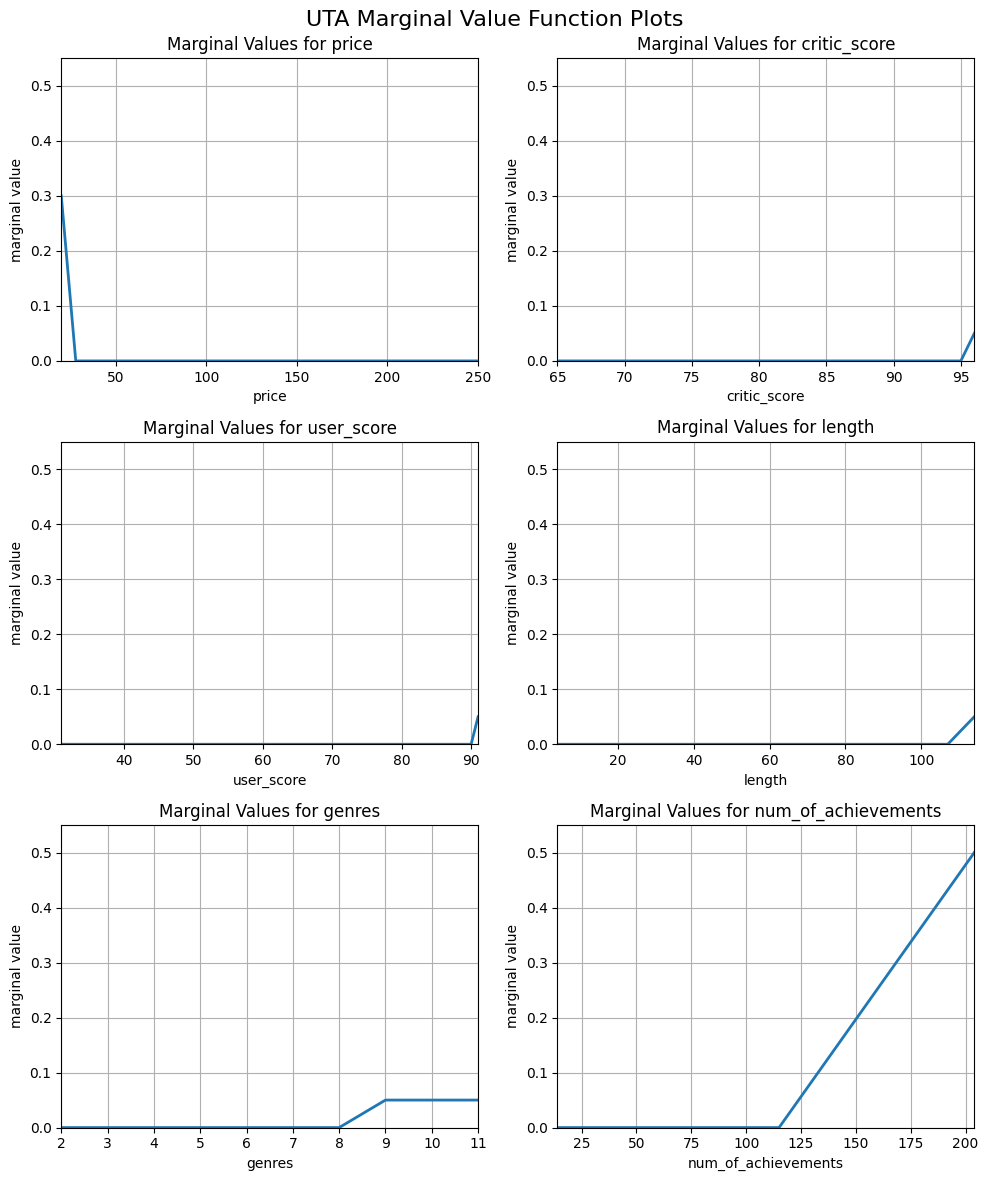

In [11]:
results_uta = solve_UTA(data_uta, criteria_types, revised_preferences)

Ranking of alternatives according to values calculated using the defined marginal value functions.

In [12]:
results_uta = admit_indifference(results_uta)
ranking_uta = [x[0] for x in results_uta]
results_uta

[('Vampire_Survivors', 0.84998),
 ('Skyrim', 0.15003),
 ('Hollow_Knight', 0.10001),
 ('Hades', 0.05003),
 ("Assassin's_Creed_Unity", 0.05002),
 ("Terraria | Baldur's_Gate_3", 0.05001),
 ('Dark_Souls:_Remastered | Dark_Souls_III | Rust | Ori_and_the_Will_of_the_Wisps | The_Forest',
  0.05),
 ('Portal_2 | Inside', 4e-05),
 ('Dishonored | Dying_Light | The_Sims_3', 2e-05),
 ('Dave_the_Diver | Teardown | Enter_the_Gungeon | Trials_Fusion | Titan_Souls',
  1e-05),
 ('Subnautica | Payday_3 | Kao_the_Kangaroo', 0.0)]

### UTA Results Description 2

As can be seen, ranking produced by UTA reflects the preferences defined earlier by the DM, furthermore, the values produced by the method can serve as additional information for the DM, which can also be a positive when it comes to this method.

When it comes to the marginal value functions, it is interesting to see, that in some cases the functions managed to reflect our expectations, for example with price being relatively important and showing high preference for very cheap games. Another positive is that genres ends up being important only past a certain threshold, which also seems appropriate. On the other hand, some aspects were very unexpected like the importance of the number of achievements.
Additionally, there are some alternatives with very high comprehensive value and many games with either very low values or with very small differences between them, which could lead to problems of interpretability and may be against the wishes of the DM. However, these problems are more likely to be caused by the dataset and defined preferences than by the method itself.

## AHP

### Criteria hierarchy:

Goal: buying a video game that is described by quality and quantity measures

```tree
3 levels:

goal
├── quality
│   ├── user_score
│   ├── critic_score
│   └── genres
└── quantity
    ├── price
    ├── length
    └── num_of_achievements

        + alternatives
```

### Pairwise comparisons of hierarchy elements:

**Comparisons were performed based on a value difference decision boundary function to skip manual selection of preferences**

<br>
User score difference preference decision boundaries: [2,4,5,6,7,9,10,15]

| US |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 0.2  | 1    | 0.25 | 1    | 9    | 0.17 | 0.25 | 1    | 0.33 | 0.5  | 1    | 0.25 | 1    | 6    | 0.5  | 1    | 1    | 2    |    9 | 6    | 9    | 8    | 3    | 9    |
|    1 | 5    | 1    | 6    | 1    | 5    | 9    | 1    | 1    | 5    | 1    | 2    | 5    | 1    | 5    | 8    | 2    | 6    | 6    | 7    |    9 | 8    | 9    | 9    | 8    | 9    |
|    2 | 1    | 0.17 | 1    | 0.17 | 1    | 9    | 0.14 | 0.17 | 1    | 0.2  | 0.33 | 1    | 0.17 | 1    | 4    | 0.33 | 1    | 1    | 1    |    9 | 4    | 9    | 7    | 2    | 9    |
|    3 | 4    | 1    | 6    | 1    | 4    | 9    | 1    | 1    | 4    | 1    | 2    | 4    | 1    | 4    | 8    | 2    | 6    | 6    | 6    |    9 | 8    | 9    | 9    | 8    | 9    |
|    4 | 1    | 0.2  | 1    | 0.25 | 1    | 9    | 0.17 | 0.25 | 1    | 0.33 | 0.5  | 1    | 0.25 | 1    | 6    | 0.5  | 1    | 1    | 2    |    9 | 6    | 9    | 8    | 3    | 9    |
|    5 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 1    | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.14 | 0.11 | 0.11 | 0.11 | 0.12 |    9 | 0.14 | 6    | 0.25 | 0.12 | 2    |
|    6 | 6    | 1    | 7    | 1    | 6    | 9    | 1    | 1    | 6    | 2    | 3    | 6    | 1    | 6    | 9    | 3    | 7    | 7    | 8    |    9 | 9    | 9    | 9    | 8    | 9    |
|    7 | 4    | 1    | 6    | 1    | 4    | 9    | 1    | 1    | 4    | 1    | 2    | 4    | 1    | 4    | 8    | 2    | 6    | 6    | 6    |    9 | 8    | 9    | 9    | 8    | 9    |
|    8 | 1    | 0.2  | 1    | 0.25 | 1    | 9    | 0.17 | 0.25 | 1    | 0.33 | 0.5  | 1    | 0.25 | 1    | 6    | 0.5  | 1    | 1    | 2    |    9 | 6    | 9    | 8    | 3    | 9    |
|    9 | 3    | 1    | 5    | 1    | 3    | 9    | 0.5  | 1    | 3    | 1    | 1    | 3    | 1    | 3    | 8    | 1    | 5    | 5    | 6    |    9 | 8    | 9    | 9    | 7    | 9    |
|   10 | 2    | 0.5  | 3    | 0.5  | 2    | 9    | 0.33 | 0.5  | 2    | 1    | 1    | 2    | 0.5  | 2    | 8    | 1    | 3    | 3    | 4    |    9 | 8    | 9    | 8    | 6    | 9    |
|   11 | 1    | 0.2  | 1    | 0.25 | 1    | 9    | 0.17 | 0.25 | 1    | 0.33 | 0.5  | 1    | 0.25 | 1    | 6    | 0.5  | 1    | 1    | 2    |    9 | 6    | 9    | 8    | 3    | 9    |
|   12 | 4    | 1    | 6    | 1    | 4    | 9    | 1    | 1    | 4    | 1    | 2    | 4    | 1    | 4    | 8    | 2    | 6    | 6    | 6    |    9 | 8    | 9    | 9    | 8    | 9    |
|   13 | 1    | 0.2  | 1    | 0.25 | 1    | 9    | 0.17 | 0.25 | 1    | 0.33 | 0.5  | 1    | 0.25 | 1    | 6    | 0.5  | 1    | 1    | 2    |    9 | 6    | 9    | 8    | 3    | 9    |
|   14 | 0.17 | 0.12 | 0.25 | 0.12 | 0.17 | 7    | 0.11 | 0.12 | 0.17 | 0.12 | 0.12 | 0.17 | 0.12 | 0.17 | 1    | 0.12 | 0.25 | 0.25 | 0.33 |    9 | 1    | 9    | 2    | 0.5  | 8    |
|   15 | 2    | 0.5  | 3    | 0.5  | 2    | 9    | 0.33 | 0.5  | 2    | 1    | 1    | 2    | 0.5  | 2    | 8    | 1    | 3    | 3    | 4    |    9 | 8    | 9    | 8    | 6    | 9    |
|   16 | 1    | 0.17 | 1    | 0.17 | 1    | 9    | 0.14 | 0.17 | 1    | 0.2  | 0.33 | 1    | 0.17 | 1    | 4    | 0.33 | 1    | 1    | 1    |    9 | 4    | 9    | 7    | 2    | 9    |
|   17 | 1    | 0.17 | 1    | 0.17 | 1    | 9    | 0.14 | 0.17 | 1    | 0.2  | 0.33 | 1    | 0.17 | 1    | 4    | 0.33 | 1    | 1    | 1    |    9 | 4    | 9    | 7    | 2    | 9    |
|   18 | 0.5  | 0.14 | 1    | 0.17 | 0.5  | 8    | 0.12 | 0.17 | 0.5  | 0.17 | 0.25 | 0.5  | 0.17 | 0.5  | 3    | 0.25 | 1    | 1    | 1    |    9 | 3    | 9    | 6    | 1    | 9    |
|   19 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 |    1 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 |
|   20 | 0.17 | 0.12 | 0.25 | 0.12 | 0.17 | 7    | 0.11 | 0.12 | 0.17 | 0.12 | 0.12 | 0.17 | 0.12 | 0.17 | 1    | 0.12 | 0.25 | 0.25 | 0.33 |    9 | 1    | 9    | 2    | 0.5  | 8    |
|   21 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.17 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 |    9 | 0.11 | 1    | 0.12 | 0.11 | 0.33 |
|   22 | 0.12 | 0.11 | 0.14 | 0.11 | 0.12 | 4    | 0.11 | 0.11 | 0.12 | 0.11 | 0.12 | 0.12 | 0.11 | 0.12 | 0.5  | 0.12 | 0.14 | 0.14 | 0.17 |    9 | 0.5  | 8    | 1    | 0.2  | 7    |
|   23 | 0.33 | 0.12 | 0.5  | 0.12 | 0.33 | 8    | 0.12 | 0.12 | 0.33 | 0.14 | 0.17 | 0.33 | 0.12 | 0.33 | 2    | 0.17 | 0.5  | 0.5  | 1    |    9 | 2    | 9    | 5    | 1    | 9    |
|   24 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.5  | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.12 | 0.11 | 0.11 | 0.11 | 0.11 |    9 | 0.12 | 3    | 0.14 | 0.11 | 1    |

<br>
Critic score difference preference decision boundaries: [2,4,5,6,7,9,10,15]

| CS |    0 |    1 |    2 |    3 |    4 |   5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 0.33 | 2    | 0.12 | 0.25 | 8   | 0.25 | 0.12 | 1    | 0.17 | 0.5  | 0.5  | 0.25 | 0.17 | 1    | 0.12 | 2    | 7    | 1    |    9 |    9 | 8    | 3    | 1    | 7    |
|    1 | 3    | 1    | 6    | 0.2  | 1    | 9   | 1    | 0.25 | 2    | 0.5  | 1    | 1    | 1    | 0.5  | 4    | 0.2  | 6    | 8    | 5    |    9 |    9 | 9    | 7    | 4    | 8    |
|    2 | 0.5  | 0.17 | 1    | 0.12 | 0.17 | 8   | 0.17 | 0.12 | 0.33 | 0.12 | 0.25 | 0.2  | 0.17 | 0.12 | 1    | 0.12 | 1    | 5    | 1    |    8 |    9 | 6    | 1    | 1    | 5    |
|    3 | 8    | 5    | 8    | 1    | 4    | 9   | 4    | 1    | 7    | 2    | 6    | 6    | 4    | 2    | 8    | 1    | 9    | 9    | 8    |    9 |    9 | 9    | 9    | 8    | 9    |
|    4 | 4    | 1    | 6    | 0.25 | 1    | 9   | 1    | 0.33 | 2    | 0.5  | 2    | 1    | 1    | 0.5  | 5    | 0.25 | 7    | 9    | 6    |    9 |    9 | 9    | 8    | 5    | 9    |
|    5 | 0.12 | 0.11 | 0.12 | 0.11 | 0.11 | 1   | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.12 | 0.11 | 0.12 | 0.33 | 0.12 |    2 |    2 | 0.5  | 0.14 | 0.12 | 0.33 |
|    6 | 4    | 1    | 6    | 0.25 | 1    | 9   | 1    | 0.33 | 2    | 0.5  | 2    | 1    | 1    | 0.5  | 5    | 0.25 | 7    | 9    | 6    |    9 |    9 | 9    | 8    | 5    | 9    |
|    7 | 8    | 4    | 8    | 1    | 3    | 9   | 3    | 1    | 6    | 1    | 6    | 5    | 3    | 1    | 8    | 1    | 8    | 9    | 8    |    9 |    9 | 9    | 9    | 8    | 9    |
|    8 | 1    | 0.5  | 3    | 0.14 | 0.5  | 9   | 0.5  | 0.17 | 1    | 0.2  | 1    | 1    | 0.5  | 0.2  | 2    | 0.14 | 4    | 8    | 2    |    9 |    9 | 8    | 5    | 2    | 8    |
|    9 | 6    | 2    | 8    | 0.5  | 2    | 9   | 2    | 1    | 5    | 1    | 4    | 3    | 2    | 1    | 7    | 0.5  | 8    | 9    | 8    |    9 |    9 | 9    | 8    | 7    | 9    |
|   10 | 2    | 1    | 4    | 0.17 | 0.5  | 9   | 0.5  | 0.17 | 1    | 0.25 | 1    | 1    | 0.5  | 0.25 | 2    | 0.17 | 5    | 8    | 3    |    9 |    9 | 8    | 6    | 2    | 8    |
|   11 | 2    | 1    | 5    | 0.17 | 1    | 9   | 1    | 0.2  | 1    | 0.33 | 1    | 1    | 1    | 0.33 | 3    | 0.17 | 6    | 8    | 4    |    9 |    9 | 9    | 6    | 3    | 8    |
|   12 | 4    | 1    | 6    | 0.25 | 1    | 9   | 1    | 0.33 | 2    | 0.5  | 2    | 1    | 1    | 0.5  | 5    | 0.25 | 7    | 9    | 6    |    9 |    9 | 9    | 8    | 5    | 9    |
|   13 | 6    | 2    | 8    | 0.5  | 2    | 9   | 2    | 1    | 5    | 1    | 4    | 3    | 2    | 1    | 7    | 0.5  | 8    | 9    | 8    |    9 |    9 | 9    | 8    | 7    | 9    |
|   14 | 1    | 0.25 | 1    | 0.12 | 0.2  | 8   | 0.2  | 0.12 | 0.5  | 0.14 | 0.5  | 0.33 | 0.2  | 0.14 | 1    | 0.12 | 2    | 6    | 1    |    9 |    9 | 8    | 2    | 1    | 6    |
|   15 | 8    | 5    | 8    | 1    | 4    | 9   | 4    | 1    | 7    | 2    | 6    | 6    | 4    | 2    | 8    | 1    | 9    | 9    | 8    |    9 |    9 | 9    | 9    | 8    | 9    |
|   16 | 0.5  | 0.17 | 1    | 0.11 | 0.14 | 8   | 0.14 | 0.12 | 0.25 | 0.12 | 0.2  | 0.17 | 0.14 | 0.12 | 0.5  | 0.11 | 1    | 4    | 1    |    8 |    8 | 6    | 1    | 0.5  | 4    |
|   17 | 0.14 | 0.12 | 0.2  | 0.11 | 0.11 | 3   | 0.11 | 0.11 | 0.12 | 0.11 | 0.12 | 0.12 | 0.11 | 0.11 | 0.17 | 0.11 | 0.25 | 1    | 0.17 |    6 |    6 | 1    | 0.33 | 0.17 | 1    |
|   18 | 1    | 0.2  | 1    | 0.12 | 0.17 | 8   | 0.17 | 0.12 | 0.5  | 0.12 | 0.33 | 0.25 | 0.17 | 0.12 | 1    | 0.12 | 1    | 6    | 1    |    9 |    9 | 7    | 2    | 1    | 6    |
|   19 | 0.11 | 0.11 | 0.12 | 0.11 | 0.11 | 0.5 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.12 | 0.17 | 0.11 |    1 |    1 | 0.25 | 0.12 | 0.11 | 0.17 |
|   20 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.5 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.12 | 0.17 | 0.11 |    1 |    1 | 0.2  | 0.12 | 0.11 | 0.17 |
|   21 | 0.12 | 0.11 | 0.17 | 0.11 | 0.11 | 2   | 0.11 | 0.11 | 0.12 | 0.11 | 0.12 | 0.11 | 0.11 | 0.11 | 0.12 | 0.11 | 0.17 | 1    | 0.14 |    4 |    5 | 1    | 0.2  | 0.12 | 1    |
|   22 | 0.33 | 0.14 | 1    | 0.11 | 0.12 | 7   | 0.12 | 0.11 | 0.2  | 0.12 | 0.17 | 0.17 | 0.12 | 0.12 | 0.5  | 0.11 | 1    | 3    | 0.5  |    8 |    8 | 5    | 1    | 0.5  | 3    |
|   23 | 1    | 0.25 | 1    | 0.12 | 0.2  | 8   | 0.2  | 0.12 | 0.5  | 0.14 | 0.5  | 0.33 | 0.2  | 0.14 | 1    | 0.12 | 2    | 6    | 1    |    9 |    9 | 8    | 2    | 1    | 6    |
|   24 | 0.14 | 0.12 | 0.2  | 0.11 | 0.11 | 3   | 0.11 | 0.11 | 0.12 | 0.11 | 0.12 | 0.12 | 0.11 | 0.11 | 0.17 | 0.11 | 0.25 | 1    | 0.17 |    6 |    6 | 1    | 0.33 | 0.17 | 1    |

<br>
Genre score difference preference decision boundaries: [1,2,3,4,5,6,7,8]

| genres |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 1    | 2    | 3    | 4    | 1    | 1    | 4    | 2    | 2    | 6    | 3    | 1    | 5    | 2    | 1    | 5    | 6    |  7   | 6    | 3    | 1    |    9 |    8 | 3    |
|    1 | 1    | 1    | 2    | 3    | 4    | 1    | 1    | 4    | 2    | 2    | 6    | 3    | 1    | 5    | 2    | 1    | 5    | 6    |  7   | 6    | 3    | 1    |    9 |    8 | 3    |
|    2 | 0.5  | 0.5  | 1    | 1    | 2    | 1    | 1    | 2    | 1    | 1    | 4    | 1    | 1    | 3    | 1    | 0.5  | 3    | 4    |  5   | 4    | 1    | 0.5  |    7 |    6 | 1    |
|    3 | 0.33 | 0.33 | 1    | 1    | 1    | 0.5  | 0.5  | 1    | 1    | 1    | 3    | 1    | 0.5  | 2    | 1    | 0.33 | 2    | 3    |  4   | 3    | 1    | 0.33 |    6 |    5 | 1    |
|    4 | 0.25 | 0.25 | 0.5  | 1    | 1    | 0.33 | 0.33 | 1    | 0.5  | 0.5  | 2    | 1    | 0.33 | 1    | 0.5  | 0.25 | 1    | 2    |  3   | 2    | 1    | 0.25 |    5 |    4 | 1    |
|    5 | 1    | 1    | 1    | 2    | 3    | 1    | 1    | 3    | 1    | 1    | 5    | 2    | 1    | 4    | 1    | 1    | 4    | 5    |  6   | 5    | 2    | 1    |    8 |    7 | 2    |
|    6 | 1    | 1    | 1    | 2    | 3    | 1    | 1    | 3    | 1    | 1    | 5    | 2    | 1    | 4    | 1    | 1    | 4    | 5    |  6   | 5    | 2    | 1    |    8 |    7 | 2    |
|    7 | 0.25 | 0.25 | 0.5  | 1    | 1    | 0.33 | 0.33 | 1    | 0.5  | 0.5  | 2    | 1    | 0.33 | 1    | 0.5  | 0.25 | 1    | 2    |  3   | 2    | 1    | 0.25 |    5 |    4 | 1    |
|    8 | 0.5  | 0.5  | 1    | 1    | 2    | 1    | 1    | 2    | 1    | 1    | 4    | 1    | 1    | 3    | 1    | 0.5  | 3    | 4    |  5   | 4    | 1    | 0.5  |    7 |    6 | 1    |
|    9 | 0.5  | 0.5  | 1    | 1    | 2    | 1    | 1    | 2    | 1    | 1    | 4    | 1    | 1    | 3    | 1    | 0.5  | 3    | 4    |  5   | 4    | 1    | 0.5  |    7 |    6 | 1    |
|   10 | 0.17 | 0.17 | 0.25 | 0.33 | 0.5  | 0.2  | 0.2  | 0.5  | 0.25 | 0.25 | 1    | 0.33 | 0.2  | 1    | 0.25 | 0.17 | 1    | 1    |  1   | 1    | 0.33 | 0.17 |    3 |    2 | 0.33 |
|   11 | 0.33 | 0.33 | 1    | 1    | 1    | 0.5  | 0.5  | 1    | 1    | 1    | 3    | 1    | 0.5  | 2    | 1    | 0.33 | 2    | 3    |  4   | 3    | 1    | 0.33 |    6 |    5 | 1    |
|   12 | 1    | 1    | 1    | 2    | 3    | 1    | 1    | 3    | 1    | 1    | 5    | 2    | 1    | 4    | 1    | 1    | 4    | 5    |  6   | 5    | 2    | 1    |    8 |    7 | 2    |
|   13 | 0.2  | 0.2  | 0.33 | 0.5  | 1    | 0.25 | 0.25 | 1    | 0.33 | 0.33 | 1    | 0.5  | 0.25 | 1    | 0.33 | 0.2  | 1    | 1    |  2   | 1    | 0.5  | 0.2  |    4 |    3 | 0.5  |
|   14 | 0.5  | 0.5  | 1    | 1    | 2    | 1    | 1    | 2    | 1    | 1    | 4    | 1    | 1    | 3    | 1    | 0.5  | 3    | 4    |  5   | 4    | 1    | 0.5  |    7 |    6 | 1    |
|   15 | 1    | 1    | 2    | 3    | 4    | 1    | 1    | 4    | 2    | 2    | 6    | 3    | 1    | 5    | 2    | 1    | 5    | 6    |  7   | 6    | 3    | 1    |    9 |    8 | 3    |
|   16 | 0.2  | 0.2  | 0.33 | 0.5  | 1    | 0.25 | 0.25 | 1    | 0.33 | 0.33 | 1    | 0.5  | 0.25 | 1    | 0.33 | 0.2  | 1    | 1    |  2   | 1    | 0.5  | 0.2  |    4 |    3 | 0.5  |
|   17 | 0.17 | 0.17 | 0.25 | 0.33 | 0.5  | 0.2  | 0.2  | 0.5  | 0.25 | 0.25 | 1    | 0.33 | 0.2  | 1    | 0.25 | 0.17 | 1    | 1    |  1   | 1    | 0.33 | 0.17 |    3 |    2 | 0.33 |
|   18 | 0.14 | 0.14 | 0.2  | 0.25 | 0.33 | 0.17 | 0.17 | 0.33 | 0.2  | 0.2  | 1    | 0.25 | 0.17 | 0.5  | 0.2  | 0.14 | 0.5  | 1    |  1   | 1    | 0.25 | 0.14 |    2 |    1 | 0.25 |
|   19 | 0.17 | 0.17 | 0.25 | 0.33 | 0.5  | 0.2  | 0.2  | 0.5  | 0.25 | 0.25 | 1    | 0.33 | 0.2  | 1    | 0.25 | 0.17 | 1    | 1    |  1   | 1    | 0.33 | 0.17 |    3 |    2 | 0.33 |
|   20 | 0.33 | 0.33 | 1    | 1    | 1    | 0.5  | 0.5  | 1    | 1    | 1    | 3    | 1    | 0.5  | 2    | 1    | 0.33 | 2    | 3    |  4   | 3    | 1    | 0.33 |    6 |    5 | 1    |
|   21 | 1    | 1    | 2    | 3    | 4    | 1    | 1    | 4    | 2    | 2    | 6    | 3    | 1    | 5    | 2    | 1    | 5    | 6    |  7   | 6    | 3    | 1    |    9 |    8 | 3    |
|   22 | 0.11 | 0.11 | 0.14 | 0.17 | 0.2  | 0.12 | 0.12 | 0.2  | 0.14 | 0.14 | 0.33 | 0.17 | 0.12 | 0.25 | 0.14 | 0.11 | 0.25 | 0.33 |  0.5 | 0.33 | 0.17 | 0.11 |    1 |    1 | 0.17 |
|   23 | 0.12 | 0.12 | 0.17 | 0.2  | 0.25 | 0.14 | 0.14 | 0.25 | 0.17 | 0.17 | 0.5  | 0.2  | 0.14 | 0.33 | 0.17 | 0.12 | 0.33 | 0.5  |  1   | 0.5  | 0.2  | 0.12 |    1 |    1 | 0.2  |
|   24 | 0.33 | 0.33 | 1    | 1    | 1    | 0.5  | 0.5  | 1    | 1    | 1    | 3    | 1    | 0.5  | 2    | 1    | 0.33 | 2    | 3    |  4   | 3    | 1    | 0.33 |    6 |    5 | 1    |

<br>
Length difference preference decision boundaries: [7, 12, 16, 25, 33, 40, 45, 60]

| length |    0 |    1 |    2 |    3 |    4 |    5 |    6 |   7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 1    | 0.12 | 0.11 | 2    | 1    | 1    | 5   | 4    | 1    | 1    | 5    |  5   |    6 | 3    | 0.11 | 4    | 2    | 0.25 |    6 |    6 | 2    | 4    | 0.17 |    6 |
|    1 | 1    | 1    | 0.12 | 0.12 | 4    | 2    | 1    | 6   | 4    | 1    | 1    | 5    |  5   |    7 | 4    | 0.11 | 5    | 3    | 0.33 |    6 |    7 | 3    | 5    | 0.2  |    7 |
|    2 | 8    | 8    | 1    | 1    | 9    | 9    | 8    | 9   | 9    | 8    | 8    | 9    |  9   |    9 | 9    | 0.5  | 9    | 9    | 6    |    9 |    9 | 9    | 9    | 4    |    9 |
|    3 | 9    | 8    | 1    | 1    | 9    | 9    | 9    | 9   | 9    | 8    | 9    | 9    |  9   |    9 | 9    | 1    | 9    | 9    | 7    |    9 |    9 | 9    | 9    | 5    |    9 |
|    4 | 0.5  | 0.25 | 0.11 | 0.11 | 1    | 1    | 0.5  | 4   | 1    | 0.25 | 0.5  | 3    |  3   |    5 | 1    | 0.11 | 2    | 1    | 0.2  |    4 |    4 | 1    | 2    | 0.12 |    5 |
|    5 | 1    | 0.5  | 0.11 | 0.11 | 1    | 1    | 1    | 4   | 2    | 0.5  | 1    | 4    |  4   |    5 | 2    | 0.11 | 3    | 1    | 0.25 |    5 |    5 | 1    | 3    | 0.14 |    5 |
|    6 | 1    | 1    | 0.12 | 0.11 | 2    | 1    | 1    | 5   | 4    | 1    | 1    | 4    |  5   |    6 | 3    | 0.11 | 4    | 1    | 0.25 |    5 |    6 | 1    | 4    | 0.17 |    6 |
|    7 | 0.2  | 0.17 | 0.11 | 0.11 | 0.25 | 0.25 | 0.2  | 1   | 0.5  | 0.17 | 0.2  | 1    |  1   |    2 | 0.33 | 0.11 | 0.5  | 0.25 | 0.12 |    1 |    1 | 0.25 | 0.5  | 0.11 |    2 |
|    8 | 0.25 | 0.25 | 0.11 | 0.11 | 1    | 0.5  | 0.25 | 2   | 1    | 0.25 | 0.25 | 1    |  2   |    4 | 1    | 0.11 | 1    | 0.5  | 0.17 |    3 |    4 | 0.5  | 1    | 0.12 |    4 |
|    9 | 1    | 1    | 0.12 | 0.12 | 4    | 2    | 1    | 6   | 4    | 1    | 1    | 5    |  5   |    7 | 4    | 0.11 | 5    | 3    | 0.33 |    6 |    7 | 3    | 5    | 0.2  |    7 |
|   10 | 1    | 1    | 0.12 | 0.11 | 2    | 1    | 1    | 5   | 4    | 1    | 1    | 4    |  5   |    6 | 3    | 0.11 | 4    | 1    | 0.25 |    5 |    6 | 2    | 4    | 0.17 |    6 |
|   11 | 0.2  | 0.2  | 0.11 | 0.11 | 0.33 | 0.25 | 0.25 | 1   | 1    | 0.2  | 0.25 | 1    |  1   |    3 | 0.5  | 0.11 | 1    | 0.25 | 0.14 |    2 |    2 | 0.25 | 1    | 0.12 |    3 |
|   12 | 0.2  | 0.2  | 0.11 | 0.11 | 0.33 | 0.25 | 0.2  | 1   | 0.5  | 0.2  | 0.2  | 1    |  1   |    2 | 0.5  | 0.11 | 1    | 0.25 | 0.12 |    1 |    2 | 0.25 | 1    | 0.11 |    2 |
|   13 | 0.17 | 0.14 | 0.11 | 0.11 | 0.2  | 0.2  | 0.17 | 0.5 | 0.25 | 0.14 | 0.17 | 0.33 |  0.5 |    1 | 0.25 | 0.11 | 0.25 | 0.2  | 0.12 |    1 |    1 | 0.2  | 0.25 | 0.11 |    1 |
|   14 | 0.33 | 0.25 | 0.11 | 0.11 | 1    | 0.5  | 0.33 | 3   | 1    | 0.25 | 0.33 | 2    |  2   |    4 | 1    | 0.11 | 1    | 0.5  | 0.17 |    4 |    4 | 1    | 1    | 0.12 |    4 |
|   15 | 9    | 9    | 2    | 1    | 9    | 9    | 9    | 9   | 9    | 9    | 9    | 9    |  9   |    9 | 9    | 1    | 9    | 9    | 8    |    9 |    9 | 9    | 9    | 6    |    9 |
|   16 | 0.25 | 0.2  | 0.11 | 0.11 | 0.5  | 0.33 | 0.25 | 2   | 1    | 0.2  | 0.25 | 1    |  1   |    4 | 1    | 0.11 | 1    | 0.33 | 0.17 |    2 |    3 | 0.33 | 1    | 0.12 |    4 |
|   17 | 0.5  | 0.33 | 0.11 | 0.11 | 1    | 1    | 1    | 4   | 2    | 0.33 | 1    | 4    |  4   |    5 | 2    | 0.11 | 3    | 1    | 0.2  |    5 |    5 | 1    | 3    | 0.14 |    5 |
|   18 | 4    | 3    | 0.17 | 0.14 | 5    | 4    | 4    | 8   | 6    | 3    | 4    | 7    |  8   |    8 | 6    | 0.12 | 6    | 5    | 1    |    8 |    8 | 5    | 6    | 0.33 |    8 |
|   19 | 0.17 | 0.17 | 0.11 | 0.11 | 0.25 | 0.2  | 0.2  | 1   | 0.33 | 0.17 | 0.2  | 0.5  |  1   |    1 | 0.25 | 0.11 | 0.5  | 0.2  | 0.12 |    1 |    1 | 0.25 | 0.33 | 0.11 |    1 |
|   20 | 0.17 | 0.14 | 0.11 | 0.11 | 0.25 | 0.2  | 0.17 | 1   | 0.25 | 0.14 | 0.17 | 0.5  |  0.5 |    1 | 0.25 | 0.11 | 0.33 | 0.2  | 0.12 |    1 |    1 | 0.2  | 0.33 | 0.11 |    1 |
|   21 | 0.5  | 0.33 | 0.11 | 0.11 | 1    | 1    | 1    | 4   | 2    | 0.33 | 0.5  | 4    |  4   |    5 | 1    | 0.11 | 3    | 1    | 0.2  |    4 |    5 | 1    | 2    | 0.14 |    5 |
|   22 | 0.25 | 0.2  | 0.11 | 0.11 | 0.5  | 0.33 | 0.25 | 2   | 1    | 0.2  | 0.25 | 1    |  1   |    4 | 1    | 0.11 | 1    | 0.33 | 0.17 |    3 |    3 | 0.5  | 1    | 0.12 |    4 |
|   23 | 6    | 5    | 0.25 | 0.2  | 8    | 7    | 6    | 9   | 8    | 5    | 6    | 8    |  9   |    9 | 8    | 0.17 | 8    | 7    | 3    |    9 |    9 | 7    | 8    | 1    |    9 |
|   24 | 0.17 | 0.14 | 0.11 | 0.11 | 0.2  | 0.2  | 0.17 | 0.5 | 0.25 | 0.14 | 0.17 | 0.33 |  0.5 |    1 | 0.25 | 0.11 | 0.25 | 0.2  | 0.12 |    1 |    1 | 0.2  | 0.25 | 0.11 |    1 |

<br>
Number of achievements difference preference decision boundaries: [5, 10, 15, 23, 35, 50, 65, 80]

| NoA |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 1    | 0.12 | 0.33 | 1    | 0.14 | 0.25 | 0.5  | 0.11 | 0.5  |    5 | 0.17 | 1    |    5 | 1    | 0.2  | 3    | 0.17 | 0.33 |  4   | 3    | 0.25 | 0.5  | 0.2  | 3    |
|    1 | 1    | 1    | 0.12 | 0.33 | 1    | 0.17 | 0.25 | 0.5  | 0.11 | 0.5  |    5 | 0.17 | 2    |    5 | 1    | 0.2  | 4    | 0.2  | 0.33 |  4   | 4    | 0.33 | 0.5  | 0.25 | 4    |
|    2 | 8    | 8    | 1    | 7    | 8    | 4    | 7    | 7    | 0.11 | 8    |    9 | 5    | 8    |    9 | 8    | 6    | 9    | 6    | 7    |  9   | 9    | 7    | 7    | 6    | 9    |
|    3 | 3    | 3    | 0.14 | 1    | 3    | 0.17 | 0.5  | 1    | 0.11 | 1    |    6 | 0.2  | 4    |    6 | 2    | 0.25 | 5    | 0.2  | 1    |  5   | 5    | 1    | 1    | 0.33 | 5    |
|    4 | 1    | 1    | 0.12 | 0.33 | 1    | 0.17 | 0.25 | 0.5  | 0.11 | 0.5  |    5 | 0.17 | 2    |    5 | 1    | 0.2  | 4    | 0.2  | 0.33 |  4   | 4    | 0.33 | 0.5  | 0.25 | 4    |
|    5 | 7    | 6    | 0.25 | 6    | 6    | 1    | 5    | 6    | 0.11 | 6    |    8 | 3    | 7    |    8 | 6    | 4    | 7    | 3    | 6    |  8   | 8    | 5    | 6    | 5    | 7    |
|    6 | 4    | 4    | 0.14 | 2    | 4    | 0.2  | 1    | 3    | 0.11 | 3    |    6 | 0.25 | 5    |    6 | 4    | 0.33 | 6    | 0.33 | 2    |  6   | 6    | 2    | 3    | 1    | 6    |
|    7 | 2    | 2    | 0.14 | 1    | 2    | 0.17 | 0.33 | 1    | 0.11 | 1    |    5 | 0.2  | 3    |    6 | 2    | 0.2  | 5    | 0.2  | 1    |  5   | 5    | 0.5  | 1    | 0.33 | 5    |
|    8 | 9    | 9    | 9    | 9    | 9    | 9    | 9    | 9    | 1    | 9    |    9 | 9    | 9    |    9 | 9    | 9    | 9    | 9    | 9    |  9   | 9    | 9    | 9    | 9    | 9    |
|    9 | 2    | 2    | 0.12 | 1    | 2    | 0.17 | 0.33 | 1    | 0.11 | 1    |    5 | 0.2  | 3    |    5 | 1    | 0.2  | 4    | 0.2  | 1    |  5   | 4    | 0.5  | 1    | 0.25 | 4    |
|   10 | 0.2  | 0.2  | 0.11 | 0.17 | 0.2  | 0.12 | 0.17 | 0.2  | 0.11 | 0.2  |    1 | 0.14 | 0.25 |    1 | 0.2  | 0.14 | 0.5  | 0.14 | 0.17 |  1   | 0.5  | 0.17 | 0.2  | 0.17 | 0.5  |
|   11 | 6    | 6    | 0.2  | 5    | 6    | 0.33 | 4    | 5    | 0.11 | 5    |    7 | 1    | 6    |    8 | 5    | 1    | 7    | 1    | 5    |  7   | 7    | 4    | 5    | 3    | 7    |
|   12 | 1    | 0.5  | 0.12 | 0.25 | 0.5  | 0.14 | 0.2  | 0.33 | 0.11 | 0.33 |    4 | 0.17 | 1    |    4 | 0.5  | 0.17 | 2    | 0.17 | 0.25 |  3   | 3    | 0.25 | 0.33 | 0.2  | 2    |
|   13 | 0.2  | 0.2  | 0.11 | 0.17 | 0.2  | 0.12 | 0.17 | 0.17 | 0.11 | 0.2  |    1 | 0.12 | 0.25 |    1 | 0.2  | 0.14 | 0.33 | 0.14 | 0.17 |  0.5 | 0.33 | 0.17 | 0.17 | 0.14 | 0.33 |
|   14 | 1    | 1    | 0.12 | 0.5  | 1    | 0.17 | 0.25 | 0.5  | 0.11 | 1    |    5 | 0.2  | 2    |    5 | 1    | 0.2  | 4    | 0.2  | 0.5  |  4   | 4    | 0.33 | 0.5  | 0.25 | 4    |
|   15 | 5    | 5    | 0.17 | 4    | 5    | 0.25 | 3    | 5    | 0.11 | 5    |    7 | 1    | 6    |    7 | 5    | 1    | 6    | 1    | 4    |  7   | 6    | 4    | 5    | 2    | 6    |
|   16 | 0.33 | 0.25 | 0.11 | 0.2  | 0.25 | 0.14 | 0.17 | 0.2  | 0.11 | 0.25 |    2 | 0.14 | 0.5  |    3 | 0.25 | 0.17 | 1    | 0.14 | 0.2  |  1   | 1    | 0.2  | 0.2  | 0.17 | 1    |
|   17 | 6    | 5    | 0.17 | 5    | 5    | 0.33 | 3    | 5    | 0.11 | 5    |    7 | 1    | 6    |    7 | 5    | 1    | 7    | 1    | 5    |  7   | 7    | 4    | 5    | 3    | 7    |
|   18 | 3    | 3    | 0.14 | 1    | 3    | 0.17 | 0.5  | 1    | 0.11 | 1    |    6 | 0.2  | 4    |    6 | 2    | 0.25 | 5    | 0.2  | 1    |  5   | 5    | 1    | 1    | 0.33 | 5    |
|   19 | 0.25 | 0.25 | 0.11 | 0.2  | 0.25 | 0.12 | 0.17 | 0.2  | 0.11 | 0.2  |    1 | 0.14 | 0.33 |    2 | 0.25 | 0.14 | 1    | 0.14 | 0.2  |  1   | 1    | 0.2  | 0.2  | 0.17 | 1    |
|   20 | 0.33 | 0.25 | 0.11 | 0.2  | 0.25 | 0.12 | 0.17 | 0.2  | 0.11 | 0.25 |    2 | 0.14 | 0.33 |    3 | 0.25 | 0.17 | 1    | 0.14 | 0.2  |  1   | 1    | 0.2  | 0.2  | 0.17 | 1    |
|   21 | 4    | 3    | 0.14 | 1    | 3    | 0.2  | 0.5  | 2    | 0.11 | 2    |    6 | 0.25 | 4    |    6 | 3    | 0.25 | 5    | 0.25 | 1    |  5   | 5    | 1    | 2    | 0.5  | 5    |
|   22 | 2    | 2    | 0.14 | 1    | 2    | 0.17 | 0.33 | 1    | 0.11 | 1    |    5 | 0.2  | 3    |    6 | 2    | 0.2  | 5    | 0.2  | 1    |  5   | 5    | 0.5  | 1    | 0.33 | 5    |
|   23 | 5    | 4    | 0.17 | 3    | 4    | 0.2  | 1    | 3    | 0.11 | 4    |    6 | 0.33 | 5    |    7 | 4    | 0.5  | 6    | 0.33 | 3    |  6   | 6    | 2    | 3    | 1    | 6    |
|   24 | 0.33 | 0.25 | 0.11 | 0.2  | 0.25 | 0.14 | 0.17 | 0.2  | 0.11 | 0.25 |    2 | 0.14 | 0.5  |    3 | 0.25 | 0.17 | 1    | 0.14 | 0.2  |  1   | 1    | 0.2  | 0.2  | 0.17 | 1    |

<br>
Price difference preference decision boundaries: [5, 12, 20, 35, 50, 80, 120, 150]

| price |    0 |   1 |    2 |   3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|----:|-----:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 5   | 0.14 |   7 | 0.17 | 1    | 0.14 | 0.14 | 0.12 | 0.25 | 0.5  | 0.14 | 0.2  | 0.17 | 0.17 | 0.17 | 0.25 | 0.17 | 0.14 | 3    | 0.25 | 0.25 | 0.17 | 0.12 | 0.14 |
|    1 | 0.2  | 1   | 0.11 |   5 | 0.14 | 0.2  | 0.12 | 0.11 | 0.11 | 0.14 | 0.17 | 0.11 | 0.14 | 0.12 | 0.12 | 0.14 | 0.17 | 0.14 | 0.12 | 0.25 | 0.17 | 0.17 | 0.14 | 0.11 | 0.12 |
|    2 | 7    | 9   | 1    |   9 | 5    | 7    | 4    | 1    | 0.25 | 6    | 7    | 1    | 6    | 4    | 4    | 5    | 6    | 5    | 4    | 8    | 7    | 6    | 4    | 0.33 | 4    |
|    3 | 0.14 | 0.2 | 0.11 |   1 | 0.11 | 0.14 | 0.11 | 0.11 | 0.11 | 0.12 | 0.14 | 0.11 | 0.12 | 0.11 | 0.11 | 0.11 | 0.12 | 0.11 | 0.11 | 0.14 | 0.12 | 0.12 | 0.11 | 0.11 | 0.11 |
|    4 | 6    | 7   | 0.2  |   9 | 1    | 6    | 0.25 | 0.2  | 0.17 | 4    | 5    | 0.2  | 3    | 0.33 | 0.33 | 1    | 4    | 1    | 0.25 | 6    | 5    | 4    | 0.5  | 0.17 | 0.25 |
|    5 | 1    | 5   | 0.14 |   7 | 0.17 | 1    | 0.14 | 0.14 | 0.12 | 0.2  | 0.33 | 0.14 | 0.2  | 0.14 | 0.14 | 0.17 | 0.25 | 0.17 | 0.14 | 3    | 0.25 | 0.25 | 0.17 | 0.12 | 0.14 |
|    6 | 7    | 8   | 0.25 |   9 | 4    | 7    | 1    | 0.25 | 0.2  | 5    | 6    | 0.25 | 5    | 1    | 1    | 4    | 6    | 4    | 1    | 7    | 6    | 6    | 2    | 0.2  | 1    |
|    7 | 7    | 9   | 1    |   9 | 5    | 7    | 4    | 1    | 0.25 | 6    | 7    | 1    | 6    | 4    | 4    | 5    | 6    | 5    | 4    | 8    | 7    | 6    | 4    | 0.33 | 4    |
|    8 | 8    | 9   | 4    |   9 | 6    | 8    | 5    | 4    | 1    | 7    | 7    | 4    | 7    | 6    | 6    | 6    | 7    | 6    | 5    | 8    | 7    | 7    | 6    | 2    | 5    |
|    9 | 4    | 7   | 0.17 |   8 | 0.25 | 5    | 0.2  | 0.17 | 0.14 | 1    | 4    | 0.17 | 0.5  | 0.2  | 0.2  | 0.25 | 1    | 0.25 | 0.2  | 6    | 3    | 1    | 0.25 | 0.14 | 0.2  |
|   10 | 2    | 6   | 0.14 |   7 | 0.2  | 3    | 0.17 | 0.14 | 0.14 | 0.25 | 1    | 0.14 | 0.25 | 0.17 | 0.17 | 0.2  | 0.33 | 0.2  | 0.17 | 4    | 0.5  | 0.33 | 0.17 | 0.14 | 0.17 |
|   11 | 7    | 9   | 1    |   9 | 5    | 7    | 4    | 1    | 0.25 | 6    | 7    | 1    | 6    | 4    | 4    | 5    | 6    | 5    | 4    | 8    | 7    | 6    | 4    | 0.33 | 4    |
|   12 | 5    | 7   | 0.17 |   8 | 0.33 | 5    | 0.2  | 0.17 | 0.14 | 2    | 4    | 0.17 | 1    | 0.2  | 0.2  | 0.33 | 2    | 0.33 | 0.2  | 6    | 4    | 2    | 0.25 | 0.17 | 0.2  |
|   13 | 6    | 8   | 0.25 |   9 | 3    | 7    | 1    | 0.25 | 0.17 | 5    | 6    | 0.25 | 5    | 1    | 1    | 3    | 5    | 3    | 1    | 7    | 6    | 5    | 2    | 0.2  | 1    |
|   14 | 6    | 8   | 0.25 |   9 | 3    | 7    | 1    | 0.25 | 0.17 | 5    | 6    | 0.25 | 5    | 1    | 1    | 3    | 5    | 3    | 1    | 7    | 6    | 5    | 2    | 0.2  | 1    |
|   15 | 6    | 7   | 0.2  |   9 | 1    | 6    | 0.25 | 0.2  | 0.17 | 4    | 5    | 0.2  | 3    | 0.33 | 0.33 | 1    | 4    | 1    | 0.25 | 6    | 5    | 4    | 0.5  | 0.17 | 0.25 |
|   16 | 4    | 6   | 0.17 |   8 | 0.25 | 4    | 0.17 | 0.17 | 0.14 | 1    | 3    | 0.17 | 0.5  | 0.2  | 0.2  | 0.25 | 1    | 0.25 | 0.17 | 5    | 2    | 1    | 0.2  | 0.14 | 0.17 |
|   17 | 6    | 7   | 0.2  |   9 | 1    | 6    | 0.25 | 0.2  | 0.17 | 4    | 5    | 0.2  | 3    | 0.33 | 0.33 | 1    | 4    | 1    | 0.25 | 6    | 5    | 4    | 0.5  | 0.17 | 0.25 |
|   18 | 7    | 8   | 0.25 |   9 | 4    | 7    | 1    | 0.25 | 0.2  | 5    | 6    | 0.25 | 5    | 1    | 1    | 4    | 6    | 4    | 1    | 7    | 6    | 6    | 2    | 0.2  | 1    |
|   19 | 0.33 | 4   | 0.12 |   7 | 0.17 | 0.33 | 0.14 | 0.12 | 0.12 | 0.17 | 0.25 | 0.12 | 0.17 | 0.14 | 0.14 | 0.17 | 0.2  | 0.17 | 0.14 | 1    | 0.2  | 0.2  | 0.14 | 0.12 | 0.14 |
|   20 | 4    | 6   | 0.14 |   8 | 0.2  | 4    | 0.17 | 0.14 | 0.14 | 0.33 | 2    | 0.14 | 0.25 | 0.17 | 0.17 | 0.2  | 0.5  | 0.2  | 0.17 | 5    | 1    | 0.5  | 0.2  | 0.14 | 0.17 |
|   21 | 4    | 6   | 0.17 |   8 | 0.25 | 4    | 0.17 | 0.17 | 0.14 | 1    | 3    | 0.17 | 0.5  | 0.2  | 0.2  | 0.25 | 1    | 0.25 | 0.17 | 5    | 2    | 1    | 0.2  | 0.14 | 0.17 |
|   22 | 6    | 7   | 0.25 |   9 | 2    | 6    | 0.5  | 0.25 | 0.17 | 4    | 6    | 0.25 | 4    | 0.5  | 0.5  | 2    | 5    | 2    | 0.5  | 7    | 5    | 5    | 1    | 0.17 | 0.5  |
|   23 | 8    | 9   | 3    |   9 | 6    | 8    | 5    | 3    | 0.5  | 7    | 7    | 3    | 6    | 5    | 5    | 6    | 7    | 6    | 5    | 8    | 7    | 7    | 6    | 1    | 5    |
|   24 | 7    | 8   | 0.25 |   9 | 4    | 7    | 1    | 0.25 | 0.2  | 5    | 6    | 0.25 | 5    | 1    | 1    | 4    | 6    | 4    | 1    | 7    | 6    | 6    | 2    | 0.2  | 1    |

<br>

| quality      |   user_score |   critic_score |   genres |
|:-------------|-------------:|---------------:|---------:|
| user_score   |     1        |        4       |     3    |
| critic_score |     0.25     |        1       |     0.75 |
| genres       |     0.333333 |        1.33333 |     1    |

<br>

| quantity            |    price |   length |   num_of_achievements |
|:--------------------|---------:|---------:|----------------------:|
| price               | 1        | 5        |                   7   |
| length              | 0.2      | 1        |                   1.4 |
| num_of_achievements | 0.142857 | 0.714286 |                   1   |

<br>

| goal     |   quality |   quantity |
|:---------|----------:|-----------:|
| quality  |      1    |          4 |
| quantity |      0.25 |          1 |

#### Pairwise comparisons

In [13]:
boundaries_user_score = [2,4,5,6,8,10,13,17]
comparisons_user_score = get_pairwise_comparisons(data, "user_score", boundaries_user_score)
print(comparisons_user_score.to_markdown())

|   id |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 0.2  | 1    | 0.25 | 1    | 9    | 0.2  | 0.25 | 1    | 0.33 | 0.5  | 1    | 0.25 | 1    | 5    | 0.5  | 1    | 1    | 2    |    9 | 5    | 9    | 7    | 3    | 9    |
|    1 | 5    | 1    | 6    | 1    | 5    | 9    | 1    | 1    | 5    | 1    | 2    | 5    | 1    | 5    | 8    | 2    | 6    | 6    | 6    |    9 | 8    | 9    | 9    | 7    | 9    |
|    2 | 1    | 0.17 | 1    | 0.2  | 1    | 8    | 0.17 | 0.2  | 1    | 0.2  | 0.33 | 1    | 0.2  | 1    | 4    | 0.33 | 1    | 1    | 1    |    9 | 4    | 9    | 6    | 2    | 9    |
|    3 | 4    | 1    | 5    | 1    | 4    | 9    | 1    | 1    | 4    | 1    | 2

In [14]:
boundaries_critic_score = [2,4,5,6,7,9,10,15]
comparisons_critic_score = get_pairwise_comparisons(data, "critic_score", boundaries_critic_score)
print(comparisons_critic_score.to_markdown())

|   id |    0 |    1 |    2 |    3 |    4 |   5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 0.33 | 2    | 0.12 | 0.25 | 8   | 0.25 | 0.12 | 1    | 0.17 | 0.5  | 0.5  | 0.25 | 0.17 | 1    | 0.12 | 2    | 7    | 1    |    9 |    9 | 8    | 3    | 1    | 7    |
|    1 | 3    | 1    | 6    | 0.2  | 1    | 9   | 1    | 0.25 | 2    | 0.5  | 1    | 1    | 1    | 0.5  | 4    | 0.2  | 6    | 8    | 5    |    9 |    9 | 9    | 7    | 4    | 8    |
|    2 | 0.5  | 0.17 | 1    | 0.12 | 0.17 | 8   | 0.17 | 0.12 | 0.33 | 0.12 | 0.25 | 0.2  | 0.17 | 0.12 | 1    | 0.12 | 1    | 5    | 1    |    8 |    9 | 6    | 1    | 1    | 5    |
|    3 | 8    | 5    | 8    | 1    | 4    | 9   | 4    | 1    | 7    | 2    | 6    | 

In [15]:
boundaries_genres = [1,2,3,4,5,6,7,8]
comparisons_genres_score = get_pairwise_comparisons(data, "genres", boundaries_genres)
print(comparisons_genres_score.to_markdown())

|   id |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 1    | 2    | 3    | 4    | 1    | 1    | 4    | 2    | 2    | 6    | 3    | 1    | 5    | 2    | 1    | 5    | 6    |  7   | 6    | 3    | 1    |    9 |    8 | 3    |
|    1 | 1    | 1    | 2    | 3    | 4    | 1    | 1    | 4    | 2    | 2    | 6    | 3    | 1    | 5    | 2    | 1    | 5    | 6    |  7   | 6    | 3    | 1    |    9 |    8 | 3    |
|    2 | 0.5  | 0.5  | 1    | 1    | 2    | 1    | 1    | 2    | 1    | 1    | 4    | 1    | 1    | 3    | 1    | 0.5  | 3    | 4    |  5   | 4    | 1    | 0.5  |    7 |    6 | 1    |
|    3 | 0.33 | 0.33 | 1    | 1    | 1    | 0.5  | 0.5  | 1    | 1    | 1    | 3

In [16]:
boundaries_length = [7, 12, 16, 25, 33, 40, 45, 60]
comparisons_length = get_pairwise_comparisons(data, "length", boundaries_length)
print(comparisons_length.to_markdown())

|   id |    0 |    1 |    2 |    3 |    4 |    5 |    6 |   7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 1    | 0.12 | 0.11 | 2    | 1    | 1    | 5   | 4    | 1    | 1    | 5    |  5   |    6 | 3    | 0.11 | 4    | 2    | 0.25 |    6 |    6 | 2    | 4    | 0.17 |    6 |
|    1 | 1    | 1    | 0.12 | 0.12 | 4    | 2    | 1    | 6   | 4    | 1    | 1    | 5    |  5   |    7 | 4    | 0.11 | 5    | 3    | 0.33 |    6 |    7 | 3    | 5    | 0.2  |    7 |
|    2 | 8    | 8    | 1    | 1    | 9    | 9    | 8    | 9   | 9    | 8    | 8    | 9    |  9   |    9 | 9    | 0.5  | 9    | 9    | 6    |    9 |    9 | 9    | 9    | 4    |    9 |
|    3 | 9    | 8    | 1    | 1    | 9    | 9    | 9    | 9   | 9    | 8    | 9    | 

In [17]:
boundaries_num_of_achievements = [5, 10, 15, 23, 35, 50, 65, 80]
comparisons_num_of_achievements = get_pairwise_comparisons(data, "num_of_achievements", boundaries_num_of_achievements)
print(comparisons_num_of_achievements.to_markdown())

|   id |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 1    | 0.12 | 0.33 | 1    | 0.14 | 0.25 | 0.5  | 0.11 | 0.5  |    5 | 0.17 | 1    |    5 | 1    | 0.2  | 3    | 0.17 | 0.33 |  4   | 3    | 0.25 | 0.5  | 0.2  | 3    |
|    1 | 1    | 1    | 0.12 | 0.33 | 1    | 0.17 | 0.25 | 0.5  | 0.11 | 0.5  |    5 | 0.17 | 2    |    5 | 1    | 0.2  | 4    | 0.2  | 0.33 |  4   | 4    | 0.33 | 0.5  | 0.25 | 4    |
|    2 | 8    | 8    | 1    | 7    | 8    | 4    | 7    | 7    | 0.11 | 8    |    9 | 5    | 8    |    9 | 8    | 6    | 9    | 6    | 7    |  9   | 9    | 7    | 7    | 6    | 9    |
|    3 | 3    | 3    | 0.14 | 1    | 3    | 0.17 | 0.5  | 1    | 0.11 | 1    |  

In [18]:
boundaries_price = [10, 20, 30, 40, 50, 70, 85, 100]
comparisons_price = get_pairwise_comparisons(data, "price", boundaries_price, cost=True)
print(comparisons_price.to_markdown())

|   id |    0 |   1 |    2 |   3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |   16 |   17 |   18 |   19 |   20 |   21 |   22 |   23 |   24 |
|-----:|-----:|----:|-----:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|    0 | 1    | 5   | 0.11 |   8 | 0.17 | 1    | 0.14 | 0.11 | 0.11 | 0.25 | 0.5  | 0.11 | 0.2  | 0.14 | 0.14 | 0.17 | 0.33 | 0.17 | 0.14 | 2    | 0.33 | 0.33 | 0.17 | 0.11 | 0.14 |
|    1 | 0.2  | 1   | 0.11 |   5 | 0.11 | 0.2  | 0.11 | 0.11 | 0.11 | 0.14 | 0.17 | 0.11 | 0.12 | 0.11 | 0.11 | 0.11 | 0.14 | 0.11 | 0.11 | 0.25 | 0.14 | 0.14 | 0.11 | 0.11 | 0.11 |
|    2 | 9    | 9   | 1    |   9 | 5    | 9    | 3    | 1    | 0.33 | 6    | 8    | 1    | 6    | 3    | 3    | 5    | 7    | 5    | 3    | 9    | 7    | 7    | 4    | 0.5  | 3    |
|    3 | 0.12 | 0.2 | 0.11 |   1 | 0.11 | 0.12 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 | 0.11 |

In [19]:
quality_criteria_names = ["user_score", "critic_score", "genres"]
quality_criteria_proportions = [
    [1,   4,   3  ],
    [1/4, 1,   3/4],
    [1/3, 4/3, 1  ]
]
comparisons_quality_criteria = pd.DataFrame(quality_criteria_proportions, columns=quality_criteria_names, index=quality_criteria_names)
print(comparisons_quality_criteria.to_markdown())

|              |   user_score |   critic_score |   genres |
|:-------------|-------------:|---------------:|---------:|
| user_score   |     1        |        4       |     3    |
| critic_score |     0.25     |        1       |     0.75 |
| genres       |     0.333333 |        1.33333 |     1    |


In [20]:
quantity_criteria_names = ["price", "length", "num_of_achievements"]
quantity_criteria_proportions = [
    [1,   5,   7  ],
    [1/5, 1,   7/5],
    [1/7, 5/7, 1  ]
]
comparisons_quantity_criteria = pd.DataFrame(quantity_criteria_proportions, columns=quantity_criteria_names, index=quantity_criteria_names)
print(comparisons_quantity_criteria.to_markdown())

|                     |    price |   length |   num_of_achievements |
|:--------------------|---------:|---------:|----------------------:|
| price               | 1        | 5        |                   7   |
| length              | 0.2      | 1        |                   1.4 |
| num_of_achievements | 0.142857 | 0.714286 |                   1   |


In [21]:
criteria_names = ["quality", "quantity"]
criteria_proportions = [
    [1,   4],
    [1/4, 1]
]
comparisons_criteria = pd.DataFrame(criteria_proportions, columns=criteria_names, index=criteria_names)
print(comparisons_criteria.to_markdown())

|          |   quality |   quantity |
|:---------|----------:|-----------:|
| quality  |      1    |          4 |
| quantity |      0.25 |          1 |


### Algorithm

```tree
Hierarchy tree:

goal
├── quality
│   ├── user_score
│   ├── critic_score
│   └── genres
└── quantity
    ├── price
    ├── length
    └── num_of_achievements

Hierarchy dict structure of comparison DataFrames:

root = AHP_node(quality and quantity comparison matrix, [AHP_node( ... ), AHP_node( ... )])

```

In [22]:
class AHP_node():
    '''
    Class implementing AHP algortihm node helper.
    '''
    def __init__(self, name: str, matrix: pd.DataFrame, leafs: list=None) -> None:
        '''
        Initialize instance of AHP_node
        Parameters:
            - name (str): name of the parent criteria of pairwise comparison elements
            - matrix (pd.DataFrame): DataFrame of pairwise comparisons
            - leafs (list): list of child AHP_nodes
        '''
        self.name = name
        self.matrix = matrix
        self.leafs = leafs

        self.w_prim = None
        self.w = None
        self.new_matrix = None
        self.lambda_max = None

    def set_unadjusted_priorities(self, w):
        self.w = w

    def set_new_matrix(self, new_matrix):
        self.new_matrix = new_matrix

    def set_priorities(self, w_prim):
        self.w_prim = w_prim

    def set_lambda_max(self, lambda_max):
        self.lambda_max = lambda_max


In [23]:
class AHP():
    '''
    Class implementing AHP algortihm for ranking and choice support.
    '''
    def __init__(self, root: AHP_node) -> None:
        '''
        Initialize instance of AHP
        Parameters:
            - root (AHP_node): root AHP_node
        '''

        self.random_index_saaty = [0.0, 0.0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49, 1.51, 1.48, 1.56, 1.57, 1.59,
                                    1.605, 1.61, 1.615, 1.62, 1.625, 1.63, 1.64, 1.65, 1.65, 1.66]

        self.root = root
        self.scores = {}

    def print_hierarchy(self):
        self._recursive_print(self.root, 1)

    def _recursive_print(self, node, depth):
        if node is None:
            return
        print("  " * depth + f"L{depth}. " + node.name)
        if node.leafs:
            for child in node.leafs:
                self._recursive_print(child, depth + 1)

    def calculate_weights(self, node):
        """
        Recursively traverse through the tree and calculate weights
        """
        if node.matrix is not None:
            numpy_matrix = node.matrix
            w, v = np.linalg.eig(numpy_matrix)
            w_max = w.max()

            CR = self.get_consistency_index(w_max, len(numpy_matrix))
            if CR > 0.1:
                print(f"Pairwise comparison matrix {node.name} didn't pass consistency test. CR={round(float(CR), 3)}")

            priorities = v[:,0]/v[:,0].sum()

            new_matrix = np.ones_like(numpy_matrix)
            for i in range(len(priorities)):
                for j in range(len(priorities)):
                    new_matrix[i,j] = priorities[i]/priorities[j]

            node.set_unadjusted_priorities(new_matrix[:,-1].astype(float))
            node.set_new_matrix(new_matrix.astype(float))
            node.set_priorities(priorities.astype(float))
            node.set_lambda_max(w_max.astype(float))

        if node.leafs is not None:
            for child in node.leafs:
                self.calculate_weights(child)
        else:
            return

    def get_consistency_index(self, w_max, n):
        if n <= 2:
            return 0

        return ((w_max-n)/(n-1)) / self.random_index_saaty[n-1]

    def calculate_scores(self, node, multiplier):
        if node.leafs is None:
            for i in range(len(node.w_prim)):
                try:
                    self.scores[i] += multiplier * node.w_prim[i]
                except KeyError:
                    self.scores[i] = multiplier * node.w_prim[i]

            return

        for j in range(len(node.w_prim)):
            self.calculate_scores(node.leafs[j], multiplier*node.w_prim[j])

    def solve(self):
        self.calculate_weights(self.root)
        self.calculate_scores(self.root, 1)

        return self.scores

In [24]:
num_of_achievements_node = AHP_node("num_of_achievements", comparisons_num_of_achievements)
price_node = AHP_node("price", comparisons_price)
length_node = AHP_node("length", comparisons_length)
genres_score_node = AHP_node("genres", comparisons_genres_score)
user_score_node = AHP_node("user_score", comparisons_user_score)
critic_score_node = AHP_node("critic_score", comparisons_critic_score)

quality_criteria_node = AHP_node("quality", comparisons_quality_criteria,
                                 [genres_score_node, user_score_node, critic_score_node])
quantity_criteria_node = AHP_node("quantity", comparisons_quantity_criteria,
                                [num_of_achievements_node, price_node, length_node])

goal_node = AHP_node("goal", comparisons_criteria, [quantity_criteria_node, quality_criteria_node])

ahp = AHP(goal_node)

ahp.print_hierarchy()

  L1. goal
    L2. quantity
      L3. num_of_achievements
      L3. price
      L3. length
    L2. quality
      L3. genres
      L3. user_score
      L3. critic_score


In [25]:
scores = ahp.solve()
scores = scores.items()

### AHP Ranking Description

In [26]:
ranking_ahp = []
for score in sorted(scores, key=lambda x: x[1], reverse=True):
    name = data[data['id'] == score[0]]['name'].values[0]
    ranking_ahp.append(name)

ahp_values = [x for x in zip(ranking_ahp, [round(x[1], 3) for x in sorted(scores, key=lambda x: x[1], reverse=True)])]
ahp_values = admit_indifference(ahp_values)
ranking_ahp = [x[0] for x in ahp_values]
ahp_values

[('Vampire Survivors', 0.174),
 ('Terraria', 0.115),
 ('Skyrim', 0.071),
 ('Rust', 0.069),
 ('Dishonored', 0.058),
 ('The Sims 3', 0.05),
 ('Dying Light', 0.046),
 ('Hollow Knight', 0.044),
 ("Baldur's Gate 3", 0.041),
 ('Portal 2', 0.034),
 ("Assassin's Creed Unity", 0.031),
 ('Enter the Gungeon | Hades', 0.029),
 ('Dark Souls III', 0.028),
 ('Dark Souls: Remastered', 0.024),
 ('The Forest | Ori and the Will of the Wisps', 0.023),
 ('Dave the Diver', 0.02),
 ('Trials Fusion', 0.019),
 ('Inside | Titan Souls', 0.016),
 ('Subnautica', 0.012),
 ('Kao the Kangaroo', 0.011),
 ('Teardown', 0.01),
 ('Payday 3', 0.007)]

As presented, the obtained AHP ranking is consistent with expected pairwise comparisons defined in previous project with a single exception:

- Payday 3 < Titan Souls: consistent
- Kao the Kangaroo < Hades: consistent
- Subnautica < Terraria: consistent
- Assassin's Creed Unity < Dark Souls: Remastered: NOT consistent

Both best expected alternatives are present in the top 8 results with Skyrim taking the 3rd place. Although one of the worst alternatives: Payday 3 has received the worst rating, Assassin's Creed Unity has an above average rank.

The resulting values associated with each alternative ranking can be considered valuable information for the DM. In this case we can observe that Assassin's Creed Unity is not much better than Dark Souls: Remastered.

The resulting ranking is dependent on the choice of pairwise comparison values.

### AHP Reconstructed Matrices Description

#### Critic Score

In [27]:
critic_score_node.matrix

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.33,2.00,0.12,0.25,8.0,0.25,0.12,1.00,0.17,0.50,0.50,0.25,0.17,1.00,0.12,2.00,7.00,1.00,9.0,9,8.00,3.00,1.00,7.00
1,3.00,1.00,6.00,0.20,1.00,9.0,1.00,0.25,2.00,0.50,1.00,1.00,1.00,0.50,4.00,0.20,6.00,8.00,5.00,9.0,9,9.00,7.00,4.00,8.00
2,0.50,0.17,1.00,0.12,0.17,8.0,0.17,0.12,0.33,0.12,0.25,0.20,0.17,0.12,1.00,0.12,1.00,5.00,1.00,8.0,9,6.00,1.00,1.00,5.00
3,8.00,5.00,8.00,1.00,4.00,9.0,4.00,1.00,7.00,2.00,6.00,6.00,4.00,2.00,8.00,1.00,9.00,9.00,8.00,9.0,9,9.00,9.00,8.00,9.00
4,4.00,1.00,6.00,0.25,1.00,9.0,1.00,0.33,2.00,0.50,2.00,1.00,1.00,0.50,5.00,0.25,7.00,9.00,6.00,9.0,9,9.00,8.00,5.00,9.00
5,0.12,0.11,0.12,0.11,0.11,1.0,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.12,0.11,0.12,0.33,0.12,2.0,2,0.50,0.14,0.12,0.33
6,4.00,1.00,6.00,0.25,1.00,9.0,1.00,0.33,2.00,0.50,2.00,1.00,1.00,0.50,5.00,0.25,7.00,9.00,6.00,9.0,9,9.00,8.00,5.00,9.00
7,8.00,4.00,8.00,1.00,3.00,9.0,3.00,1.00,6.00,1.00,6.00,5.00,3.00,1.00,8.00,1.00,8.00,9.00,8.00,9.0,9,9.00,9.00,8.00,9.00
8,1.00,0.50,3.00,0.14,0.50,9.0,0.50,0.17,1.00,0.20,1.00,1.00,0.50,0.20,2.00,0.14,4.00,8.00,2.00,9.0,9,8.00,5.00,2.00,8.00


In [28]:
pd.DataFrame(critic_score_node.new_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.462489,1.400646,0.178829,0.410150,4.645069,0.410150,0.205796,0.720377,0.261873,0.632709,0.531881,0.410150,0.261873,1.147926,0.178829,1.575919,3.131327,1.237836,5.245992,5.266397,3.560206,1.779857,1.147926,3.131327
1,2.162215,1.000000,3.028499,0.386666,0.886834,10.043639,0.886834,0.444975,1.557610,0.566226,1.368054,1.150040,0.886834,0.566226,2.482064,0.386666,3.407475,6.770603,2.676468,11.342964,11.387084,7.697931,3.848434,2.482064,6.770603
2,0.713956,0.330197,1.000000,0.127676,0.292829,3.316375,0.292829,0.146929,0.514318,0.186966,0.451727,0.379739,0.292829,0.186966,0.819569,0.127676,1.125137,2.235630,0.883761,3.745408,3.759976,2.541831,1.270740,0.819569,2.235630
3,5.591942,2.586209,7.832332,1.000000,2.293537,25.974954,2.293537,1.150799,4.028306,1.464379,3.538073,2.974245,2.293537,1.464379,6.419137,1.000000,8.812445,17.510196,6.921907,29.335280,29.449384,19.908462,9.952856,6.419137,17.510196
4,2.438130,1.127607,3.414958,0.436008,1.000000,11.325281,1.000000,0.501757,1.756373,0.638481,1.542627,1.296794,1.000000,0.638481,2.798793,0.436008,3.842294,7.634581,3.018005,12.790409,12.840159,8.680243,4.339522,2.798793,7.634581
5,0.215282,0.099566,0.301534,0.038499,0.088298,1.000000,0.088298,0.044304,0.155084,0.056377,0.136211,0.114504,0.088298,0.056377,0.247128,0.038499,0.339267,0.674118,0.266484,1.129368,1.133761,0.766448,0.383171,0.247128,0.674118
6,2.438130,1.127607,3.414958,0.436008,1.000000,11.325281,1.000000,0.501757,1.756373,0.638481,1.542627,1.296794,1.000000,0.638481,2.798793,0.436008,3.842294,7.634581,3.018005,12.790409,12.840159,8.680243,4.339522,2.798793,7.634581
7,4.859182,2.247316,6.805995,0.868961,1.992995,22.571233,1.992995,1.000000,3.500443,1.272489,3.074449,2.584504,1.992995,1.272489,5.577982,0.868961,7.657675,15.215686,6.014870,25.491227,25.590379,17.299686,8.648648,5.577982,15.215686
8,1.388162,0.642009,1.944324,0.248243,0.569355,6.448108,0.569355,0.285678,1.000000,0.363522,0.878303,0.738336,0.569355,0.363522,1.593508,0.248243,2.187630,4.346789,1.718317,7.282287,7.310612,4.942142,2.470730,1.593508,4.346789
9,3.818644,1.766079,5.348569,0.682883,1.566218,17.737863,1.566218,0.785861,2.750863,1.000000,2.416091,2.031062,1.566218,1.000000,4.383521,0.682883,6.017871,11.957421,4.726855,20.032573,20.110493,13.595156,6.796640,4.383521,11.957421


In [29]:
pd.DataFrame((critic_score_node.new_matrix - critic_score_node.matrix.to_numpy()).round(1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.1,-0.6,0.1,0.2,-3.4,0.2,0.1,-0.3,0.1,0.1,0.0,0.2,0.1,0.1,0.1,-0.4,-3.9,0.2,-3.8,-3.7,-4.4,-1.2,0.1,-3.9
1,-0.8,0.0,-3.0,0.2,-0.1,1.0,-0.1,0.2,-0.4,0.1,0.4,0.2,-0.1,0.1,-1.5,0.2,-2.6,-1.2,-2.3,2.3,2.4,-1.3,-3.2,-1.5,-1.2
2,0.2,0.2,0.0,0.0,0.1,-4.7,0.1,0.0,0.2,0.1,0.2,0.2,0.1,0.1,-0.2,0.0,0.1,-2.8,-0.1,-4.3,-5.2,-3.5,0.3,-0.2,-2.8
3,-2.4,-2.4,-0.2,0.0,-1.7,17.0,-1.7,0.2,-3.0,-0.5,-2.5,-3.0,-1.7,-0.5,-1.6,0.0,-0.2,8.5,-1.1,20.3,20.4,10.9,1.0,-1.6,8.5
4,-1.6,0.1,-2.6,0.2,0.0,2.3,0.0,0.2,-0.2,0.1,-0.5,0.3,0.0,0.1,-2.2,0.2,-3.2,-1.4,-3.0,3.8,3.8,-0.3,-3.7,-2.2,-1.4
5,0.1,-0.0,0.2,-0.1,-0.0,0.0,-0.0,-0.1,0.0,-0.1,0.0,0.0,-0.0,-0.1,0.1,-0.1,0.2,0.3,0.1,-0.9,-0.9,0.3,0.2,0.1,0.3
6,-1.6,0.1,-2.6,0.2,0.0,2.3,0.0,0.2,-0.2,0.1,-0.5,0.3,0.0,0.1,-2.2,0.2,-3.2,-1.4,-3.0,3.8,3.8,-0.3,-3.7,-2.2,-1.4
7,-3.1,-1.8,-1.2,-0.1,-1.0,13.6,-1.0,0.0,-2.5,0.3,-2.9,-2.4,-1.0,0.3,-2.4,-0.1,-0.3,6.2,-2.0,16.5,16.6,8.3,-0.4,-2.4,6.2
8,0.4,0.1,-1.1,0.1,0.1,-2.6,0.1,0.1,0.0,0.2,-0.1,-0.3,0.1,0.2,-0.4,0.1,-1.8,-3.7,-0.3,-1.7,-1.7,-3.1,-2.5,-0.4,-3.7
9,-2.2,-0.2,-2.7,0.2,-0.4,8.7,-0.4,-0.2,-2.2,0.0,-1.6,-1.0,-0.4,0.0,-2.6,0.2,-2.0,3.0,-3.3,11.0,11.1,4.6,-1.2,-2.6,3.0


#### User Score

In [30]:
user_score_node.matrix

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.20,1.00,0.25,1.00,9.00,0.20,0.25,1.00,0.33,0.50,1.00,0.25,1.00,5.00,0.50,1.00,1.00,2.00,9,5.00,9.00,7.00,3.00,9.00
1,5.00,1.00,6.00,1.00,5.00,9.00,1.00,1.00,5.00,1.00,2.00,5.00,1.00,5.00,8.00,2.00,6.00,6.00,6.00,9,8.00,9.00,9.00,7.00,9.00
2,1.00,0.17,1.00,0.20,1.00,8.00,0.17,0.20,1.00,0.20,0.33,1.00,0.20,1.00,4.00,0.33,1.00,1.00,1.00,9,4.00,9.00,6.00,2.00,9.00
3,4.00,1.00,5.00,1.00,4.00,9.00,1.00,1.00,4.00,1.00,2.00,4.00,1.00,4.00,8.00,2.00,5.00,5.00,6.00,9,8.00,9.00,9.00,7.00,9.00
4,1.00,0.20,1.00,0.25,1.00,9.00,0.20,0.25,1.00,0.33,0.50,1.00,0.25,1.00,5.00,0.50,1.00,1.00,2.00,9,5.00,9.00,7.00,3.00,9.00
5,0.11,0.11,0.12,0.11,0.11,1.00,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.17,0.11,0.12,0.12,0.12,9,0.17,6.00,0.25,0.14,2.00
6,5.00,1.00,6.00,1.00,5.00,9.00,1.00,1.00,5.00,2.00,3.00,5.00,1.00,5.00,8.00,3.00,6.00,6.00,7.00,9,8.00,9.00,9.00,7.00,9.00
7,4.00,1.00,5.00,1.00,4.00,9.00,1.00,1.00,4.00,1.00,2.00,4.00,1.00,4.00,8.00,2.00,5.00,5.00,6.00,9,8.00,9.00,9.00,7.00,9.00
8,1.00,0.20,1.00,0.25,1.00,9.00,0.20,0.25,1.00,0.33,0.50,1.00,0.25,1.00,5.00,0.50,1.00,1.00,2.00,9,5.00,9.00,7.00,3.00,9.00


In [31]:
pd.DataFrame(user_score_node.new_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.327776,1.165092,0.358713,1.000000,4.673844,0.305068,0.358713,1.000000,0.424762,0.574586,1.000000,0.358713,1.000000,2.510468,0.574586,1.165092,1.165092,1.423139,8.143274,2.510468,6.099638,3.287085,1.798554,5.463155
1,3.050861,1.000000,3.554535,1.094385,3.050861,14.259252,0.930721,1.094385,3.050861,1.295889,1.752983,3.050861,1.094385,3.050861,7.659089,1.752983,3.554535,3.554535,4.341801,24.844000,7.659089,18.609149,10.028442,5.487139,16.667328
2,0.858301,0.281331,1.000000,0.307884,0.858301,4.011566,0.261841,0.307884,0.858301,0.364573,0.493168,0.858301,0.307884,0.858301,2.154737,0.493168,1.000000,1.000000,1.221482,6.989381,2.154737,5.235326,2.821309,1.543701,4.689032
3,2.787741,0.913755,3.247975,1.000000,2.787741,13.029466,0.850451,1.000000,2.787741,1.184125,1.601798,2.787741,1.000000,2.787741,6.998533,1.601798,3.247975,3.247975,3.967344,22.701335,6.998533,17.004208,9.163541,5.013902,15.229858
4,1.000000,0.327776,1.165092,0.358713,1.000000,4.673844,0.305068,0.358713,1.000000,0.424762,0.574586,1.000000,0.358713,1.000000,2.510468,0.574586,1.165092,1.165092,1.423139,8.143274,2.510468,6.099638,3.287085,1.798554,5.463155
5,0.213957,0.070130,0.249279,0.076749,0.213957,1.000000,0.065271,0.076749,0.213957,0.090881,0.122937,0.213957,0.076749,0.213957,0.537131,0.122937,0.249279,0.249279,0.304490,1.742307,0.537131,1.305058,0.703294,0.384813,1.168878
6,3.277954,1.074436,3.819119,1.175846,3.277954,15.320647,1.000000,1.175846,3.277954,1.392349,1.883468,3.277954,1.175846,3.277954,8.229197,1.883468,3.819119,3.819119,4.664985,26.693277,8.229197,19.994332,10.774914,5.895577,17.907970
7,2.787741,0.913755,3.247975,1.000000,2.787741,13.029466,0.850451,1.000000,2.787741,1.184125,1.601798,2.787741,1.000000,2.787741,6.998533,1.601798,3.247975,3.247975,3.967344,22.701335,6.998533,17.004208,9.163541,5.013902,15.229858
8,1.000000,0.327776,1.165092,0.358713,1.000000,4.673844,0.305068,0.358713,1.000000,0.424762,0.574586,1.000000,0.358713,1.000000,2.510468,0.574586,1.165092,1.165092,1.423139,8.143274,2.510468,6.099638,3.287085,1.798554,5.463155
9,2.354261,0.771671,2.742932,0.844505,2.354261,11.003452,0.718211,0.844505,2.354261,1.000000,1.352727,2.354261,0.844505,2.354261,5.910297,1.352727,2.742932,2.742932,3.350442,19.171395,5.910297,14.360141,7.738658,4.234266,12.861694


In [32]:
pd.DataFrame((user_score_node.new_matrix - user_score_node.matrix.to_numpy()).round(1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.1,0.2,0.1,-0.0,-4.3,0.1,0.1,-0.0,0.1,0.1,-0.0,0.1,-0.0,-2.5,0.1,0.2,0.2,-0.6,-0.9,-2.5,-2.9,-3.7,-1.2,-3.5
1,-1.9,0.0,-2.4,0.1,-1.9,5.3,-0.1,0.1,-1.9,0.3,-0.2,-1.9,0.1,-1.9,-0.3,-0.2,-2.4,-2.4,-1.7,15.8,-0.3,9.6,1.0,-1.5,7.7
2,-0.1,0.1,-0.0,0.1,-0.1,-4.0,0.1,0.1,-0.1,0.2,0.2,-0.1,0.1,-0.1,-1.8,0.2,-0.0,-0.0,0.2,-2.0,-1.8,-3.8,-3.2,-0.5,-4.3
3,-1.2,-0.1,-1.8,-0.0,-1.2,4.0,-0.1,-0.0,-1.2,0.2,-0.4,-1.2,-0.0,-1.2,-1.0,-0.4,-1.8,-1.8,-2.0,13.7,-1.0,8.0,0.2,-2.0,6.2
4,0.0,0.1,0.2,0.1,0.0,-4.3,0.1,0.1,0.0,0.1,0.1,0.0,0.1,0.0,-2.5,0.1,0.2,0.2,-0.6,-0.9,-2.5,-2.9,-3.7,-1.2,-3.5
5,0.1,-0.0,0.1,-0.0,0.1,0.0,-0.0,-0.0,0.1,-0.0,0.0,0.1,-0.0,0.1,0.4,0.0,0.1,0.1,0.2,-7.3,0.4,-4.7,0.5,0.2,-0.8
6,-1.7,0.1,-2.2,0.2,-1.7,6.3,-0.0,0.2,-1.7,-0.6,-1.1,-1.7,0.2,-1.7,0.2,-1.1,-2.2,-2.2,-2.3,17.7,0.2,11.0,1.8,-1.1,8.9
7,-1.2,-0.1,-1.8,-0.0,-1.2,4.0,-0.1,-0.0,-1.2,0.2,-0.4,-1.2,-0.0,-1.2,-1.0,-0.4,-1.8,-1.8,-2.0,13.7,-1.0,8.0,0.2,-2.0,6.2
8,0.0,0.1,0.2,0.1,0.0,-4.3,0.1,0.1,0.0,0.1,0.1,0.0,0.1,0.0,-2.5,0.1,0.2,0.2,-0.6,-0.9,-2.5,-2.9,-3.7,-1.2,-3.5
9,-0.6,-0.2,-2.3,-0.2,-0.6,2.0,0.2,-0.2,-0.6,0.0,0.4,-0.6,-0.2,-0.6,-1.1,0.4,-2.3,-2.3,-1.6,10.2,-1.1,5.4,-0.3,-1.8,3.9


#### Genres Score

In [33]:
genres_score_node.matrix

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,1.00,2.00,3.00,4.00,1.00,1.00,4.00,2.00,2.00,6.00,3.00,1.00,5.00,2.00,1.00,5.00,6.00,7.0,6.00,3.00,1.00,9,8.0,3.00
1,1.00,1.00,2.00,3.00,4.00,1.00,1.00,4.00,2.00,2.00,6.00,3.00,1.00,5.00,2.00,1.00,5.00,6.00,7.0,6.00,3.00,1.00,9,8.0,3.00
2,0.50,0.50,1.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,4.00,1.00,1.00,3.00,1.00,0.50,3.00,4.00,5.0,4.00,1.00,0.50,7,6.0,1.00
3,0.33,0.33,1.00,1.00,1.00,0.50,0.50,1.00,1.00,1.00,3.00,1.00,0.50,2.00,1.00,0.33,2.00,3.00,4.0,3.00,1.00,0.33,6,5.0,1.00
4,0.25,0.25,0.50,1.00,1.00,0.33,0.33,1.00,0.50,0.50,2.00,1.00,0.33,1.00,0.50,0.25,1.00,2.00,3.0,2.00,1.00,0.25,5,4.0,1.00
5,1.00,1.00,1.00,2.00,3.00,1.00,1.00,3.00,1.00,1.00,5.00,2.00,1.00,4.00,1.00,1.00,4.00,5.00,6.0,5.00,2.00,1.00,8,7.0,2.00
6,1.00,1.00,1.00,2.00,3.00,1.00,1.00,3.00,1.00,1.00,5.00,2.00,1.00,4.00,1.00,1.00,4.00,5.00,6.0,5.00,2.00,1.00,8,7.0,2.00
7,0.25,0.25,0.50,1.00,1.00,0.33,0.33,1.00,0.50,0.50,2.00,1.00,0.33,1.00,0.50,0.25,1.00,2.00,3.0,2.00,1.00,0.25,5,4.0,1.00
8,0.50,0.50,1.00,1.00,2.00,1.00,1.00,2.00,1.00,1.00,4.00,1.00,1.00,3.00,1.00,0.50,3.00,4.00,5.0,4.00,1.00,0.50,7,6.0,1.00


In [34]:
pd.DataFrame(genres_score_node.new_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.000000,1.000000,1.781586,2.387229,3.329339,1.288955,1.288955,3.329339,1.781586,1.781586,6.388171,2.387229,1.288955,4.823800,1.781586,1.000000,4.823800,6.388171,8.292859,6.388171,2.387229,1.000000,13.193225,10.888445,2.387229
1,1.000000,1.000000,1.781586,2.387229,3.329339,1.288955,1.288955,3.329339,1.781586,1.781586,6.388171,2.387229,1.288955,4.823800,1.781586,1.000000,4.823800,6.388171,8.292859,6.388171,2.387229,1.000000,13.193225,10.888445,2.387229
2,0.561298,0.561298,1.000000,1.339947,1.868751,0.723488,0.723488,1.868751,1.000000,1.000000,3.585666,1.339947,0.723488,2.707588,1.000000,0.561298,2.707588,3.585666,4.654763,3.585666,1.339947,0.561298,7.405328,6.111660,1.339947
3,0.418896,0.418896,0.746298,1.000000,1.394646,0.539938,0.539938,1.394646,0.746298,0.746298,2.675977,1.000000,0.539938,2.020669,0.746298,0.418896,2.020669,2.675977,3.473842,2.675977,1.000000,0.418896,5.526584,4.561122,1.000000
4,0.300360,0.300360,0.535117,0.717028,1.000000,0.387150,0.387150,1.000000,0.535117,0.535117,1.918750,0.717028,0.387150,1.448876,0.535117,0.300360,1.448876,1.918750,2.490842,1.918750,0.717028,0.300360,3.962716,3.270452,0.717028
5,0.775822,0.775822,1.382194,1.852065,2.582975,1.000000,1.000000,2.582975,1.382194,1.382194,4.956085,1.852065,1.000000,3.742411,1.382194,0.775822,3.742411,4.956085,6.433784,4.956085,1.852065,0.775822,10.235596,8.447496,1.852065
6,0.775822,0.775822,1.382194,1.852065,2.582975,1.000000,1.000000,2.582975,1.382194,1.382194,4.956085,1.852065,1.000000,3.742411,1.382194,0.775822,3.742411,4.956085,6.433784,4.956085,1.852065,0.775822,10.235596,8.447496,1.852065
7,0.300360,0.300360,0.535117,0.717028,1.000000,0.387150,0.387150,1.000000,0.535117,0.535117,1.918750,0.717028,0.387150,1.448876,0.535117,0.300360,1.448876,1.918750,2.490842,1.918750,0.717028,0.300360,3.962716,3.270452,0.717028
8,0.561298,0.561298,1.000000,1.339947,1.868751,0.723488,0.723488,1.868751,1.000000,1.000000,3.585666,1.339947,0.723488,2.707588,1.000000,0.561298,2.707588,3.585666,4.654763,3.585666,1.339947,0.561298,7.405328,6.111660,1.339947
9,0.561298,0.561298,1.000000,1.339947,1.868751,0.723488,0.723488,1.868751,1.000000,1.000000,3.585666,1.339947,0.723488,2.707588,1.000000,0.561298,2.707588,3.585666,4.654763,3.585666,1.339947,0.561298,7.405328,6.111660,1.339947


In [35]:
pd.DataFrame((genres_score_node.new_matrix - genres_score_node.matrix.to_numpy()).round(1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,-0.2,-0.6,-0.7,0.3,0.3,-0.7,-0.2,-0.2,0.4,-0.6,0.3,-0.2,-0.2,0.0,-0.2,0.4,1.3,0.4,-0.6,0.0,4.2,2.9,-0.6
1,-0.0,0.0,-0.2,-0.6,-0.7,0.3,0.3,-0.7,-0.2,-0.2,0.4,-0.6,0.3,-0.2,-0.2,0.0,-0.2,0.4,1.3,0.4,-0.6,0.0,4.2,2.9,-0.6
2,0.1,0.1,0.0,0.3,-0.1,-0.3,-0.3,-0.1,-0.0,-0.0,-0.4,0.3,-0.3,-0.3,-0.0,0.1,-0.3,-0.4,-0.3,-0.4,0.3,0.1,0.4,0.1,0.3
3,0.1,0.1,-0.3,0.0,0.4,0.0,0.0,0.4,-0.3,-0.3,-0.3,0.0,0.0,0.0,-0.3,0.1,0.0,-0.3,-0.5,-0.3,0.0,0.1,-0.5,-0.4,0.0
4,0.1,0.1,0.0,-0.3,0.0,0.1,0.1,0.0,0.0,0.0,-0.1,-0.3,0.1,0.4,0.0,0.1,0.4,-0.1,-0.5,-0.1,-0.3,0.1,-1.0,-0.7,-0.3
5,-0.2,-0.2,0.4,-0.1,-0.4,0.0,0.0,-0.4,0.4,0.4,-0.0,-0.1,0.0,-0.3,0.4,-0.2,-0.3,-0.0,0.4,-0.0,-0.1,-0.2,2.2,1.4,-0.1
6,-0.2,-0.2,0.4,-0.1,-0.4,0.0,0.0,-0.4,0.4,0.4,-0.0,-0.1,0.0,-0.3,0.4,-0.2,-0.3,-0.0,0.4,-0.0,-0.1,-0.2,2.2,1.4,-0.1
7,0.1,0.1,0.0,-0.3,0.0,0.1,0.1,0.0,0.0,0.0,-0.1,-0.3,0.1,0.4,0.0,0.1,0.4,-0.1,-0.5,-0.1,-0.3,0.1,-1.0,-0.7,-0.3
8,0.1,0.1,0.0,0.3,-0.1,-0.3,-0.3,-0.1,0.0,0.0,-0.4,0.3,-0.3,-0.3,0.0,0.1,-0.3,-0.4,-0.3,-0.4,0.3,0.1,0.4,0.1,0.3
9,0.1,0.1,0.0,0.3,-0.1,-0.3,-0.3,-0.1,0.0,0.0,-0.4,0.3,-0.3,-0.3,0.0,0.1,-0.3,-0.4,-0.3,-0.4,0.3,0.1,0.4,0.1,0.3


#### Price

In [36]:
price_node.matrix

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,5.0,0.11,8,0.17,1.00,0.14,0.11,0.11,0.25,0.50,0.11,0.20,0.14,0.14,0.17,0.33,0.17,0.14,2.00,0.33,0.33,0.17,0.11,0.14
1,0.20,1.0,0.11,5,0.11,0.20,0.11,0.11,0.11,0.14,0.17,0.11,0.12,0.11,0.11,0.11,0.14,0.11,0.11,0.25,0.14,0.14,0.11,0.11,0.11
2,9.00,9.0,1.00,9,5.00,9.00,3.00,1.00,0.33,6.00,8.00,1.00,6.00,3.00,3.00,5.00,7.00,5.00,3.00,9.00,7.00,7.00,4.00,0.50,3.00
3,0.12,0.2,0.11,1,0.11,0.12,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.14,0.11,0.11,0.11,0.11,0.11
4,6.00,9.0,0.20,9,1.00,6.00,0.33,0.20,0.14,3.00,5.00,0.20,2.00,0.50,0.50,1.00,3.00,1.00,0.33,7.00,4.00,3.00,0.50,0.17,0.33
5,1.00,5.0,0.11,8,0.17,1.00,0.14,0.11,0.11,0.25,0.50,0.11,0.20,0.14,0.14,0.17,0.25,0.17,0.14,2.00,0.33,0.25,0.14,0.11,0.14
6,7.00,9.0,0.33,9,3.00,7.00,1.00,0.33,0.20,5.00,7.00,0.33,4.00,1.00,1.00,3.00,6.00,3.00,1.00,9.00,6.00,6.00,2.00,0.25,1.00
7,9.00,9.0,1.00,9,5.00,9.00,3.00,1.00,0.33,6.00,8.00,1.00,6.00,3.00,3.00,5.00,7.00,5.00,3.00,9.00,7.00,7.00,4.00,0.50,3.00
8,9.00,9.0,3.00,9,7.00,9.00,5.00,3.00,1.00,8.00,9.00,3.00,8.00,6.00,6.00,6.00,8.00,6.00,5.00,9.00,9.00,8.00,6.00,1.00,5.00


In [37]:
pd.DataFrame(price_node.new_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.000000,1.602169,0.089497,1.944633,0.288030,1.014874,0.157379,0.089497,0.055015,0.496602,0.791628,0.089497,0.405084,0.179306,0.179306,0.280067,0.570780,0.280067,0.157379,1.230466,0.652719,0.570780,0.221886,0.063616,0.157379
1,0.624154,1.000000,0.055860,1.213750,0.179775,0.633437,0.098229,0.055860,0.034338,0.309956,0.494098,0.055860,0.252835,0.111915,0.111915,0.174805,0.356254,0.174805,0.098229,0.768000,0.407397,0.356254,0.138491,0.039706,0.098229
2,11.173590,17.901981,1.000000,21.728536,3.218327,11.339781,1.758486,1.000000,0.614715,5.548825,8.845329,1.000000,4.526240,2.003491,2.003491,3.129354,6.377660,3.129354,1.758486,13.748719,7.293212,6.377660,2.479259,0.710819,1.758486
3,0.514236,0.823893,0.046022,1.000000,0.148115,0.521884,0.080930,0.046022,0.028291,0.255370,0.407084,0.046022,0.208309,0.092206,0.092206,0.144020,0.293515,0.144020,0.080930,0.632749,0.335651,0.293515,0.114102,0.032714,0.080930
4,3.471862,5.562511,0.310720,6.751500,1.000000,3.523501,0.546398,0.310720,0.191004,1.724133,2.748424,0.310720,1.406395,0.622526,0.622526,0.972354,1.981669,0.972354,0.546398,4.272008,2.266150,1.981669,0.770357,0.220866,0.546398
5,0.985344,1.578688,0.088185,1.916134,0.283809,1.000000,0.155072,0.088185,0.054209,0.489324,0.780026,0.088185,0.399147,0.176678,0.176678,0.275962,0.562415,0.275962,0.155072,1.212433,0.643153,0.562415,0.218634,0.062684,0.155072
6,6.354096,10.180336,0.568671,12.356387,1.830169,6.448604,1.000000,0.568671,0.349570,3.155456,5.030082,0.568671,2.573941,1.139327,1.139327,1.779573,3.626790,1.779573,1.000000,7.818497,4.147438,3.626790,1.409883,0.404222,1.000000
7,11.173590,17.901981,1.000000,21.728536,3.218327,11.339781,1.758486,1.000000,0.614715,5.548825,8.845329,1.000000,4.526240,2.003491,2.003491,3.129354,6.377660,3.129354,1.758486,13.748719,7.293212,6.377660,2.479259,0.710819,1.758486
8,18.176870,29.122421,1.626771,35.347350,5.235481,18.447225,2.860654,1.626771,1.000000,9.026667,14.389324,1.626771,7.363155,3.259222,3.259222,5.090742,10.374991,5.090742,2.860654,22.366016,11.864384,10.374991,4.033187,1.156339,2.860654
9,2.013686,3.226265,0.180218,3.915880,0.580002,2.043636,0.316911,0.180218,0.110783,1.000000,1.594090,0.180218,0.815711,0.361066,0.361066,0.563967,1.149371,0.563967,0.316911,2.477771,1.314370,1.149371,0.446808,0.128103,0.316911


In [38]:
pd.DataFrame((price_node.new_matrix - price_node.matrix.to_numpy()).round(1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,-3.4,-0.0,-6.1,0.1,0.0,0.0,-0.0,-0.1,0.2,0.3,-0.0,0.2,0.0,0.0,0.1,0.2,0.1,0.0,-0.8,0.3,0.2,0.1,-0.0,0.0
1,0.4,0.0,-0.1,-3.8,0.1,0.4,-0.0,-0.1,-0.1,0.2,0.3,-0.1,0.1,0.0,0.0,0.1,0.2,0.1,-0.0,0.5,0.3,0.2,0.0,-0.1,-0.0
2,2.2,8.9,0.0,12.7,-1.8,2.3,-1.2,0.0,0.3,-0.5,0.8,0.0,-1.5,-1.0,-1.0,-1.9,-0.6,-1.9,-1.2,4.7,0.3,-0.6,-1.5,0.2,-1.2
3,0.4,0.6,-0.1,0.0,0.0,0.4,-0.0,-0.1,-0.1,0.1,0.3,-0.1,0.1,-0.0,-0.0,0.0,0.2,0.0,-0.0,0.5,0.2,0.2,0.0,-0.1,-0.0
4,-2.5,-3.4,0.1,-2.2,0.0,-2.5,0.2,0.1,0.1,-1.3,-2.3,0.1,-0.6,0.1,0.1,-0.0,-1.0,-0.0,0.2,-2.7,-1.7,-1.0,0.3,0.1,0.2
5,-0.0,-3.4,-0.0,-6.1,0.1,0.0,0.0,-0.0,-0.1,0.2,0.3,-0.0,0.2,0.0,0.0,0.1,0.3,0.1,0.0,-0.8,0.3,0.3,0.1,-0.0,0.0
6,-0.6,1.2,0.2,3.4,-1.2,-0.6,0.0,0.2,0.1,-1.8,-2.0,0.2,-1.4,0.1,0.1,-1.2,-2.4,-1.2,0.0,-1.2,-1.9,-2.4,-0.6,0.2,0.0
7,2.2,8.9,0.0,12.7,-1.8,2.3,-1.2,0.0,0.3,-0.5,0.8,0.0,-1.5,-1.0,-1.0,-1.9,-0.6,-1.9,-1.2,4.7,0.3,-0.6,-1.5,0.2,-1.2
8,9.2,20.1,-1.4,26.3,-1.8,9.4,-2.1,-1.4,0.0,1.0,5.4,-1.4,-0.6,-2.7,-2.7,-0.9,2.4,-0.9,-2.1,13.4,2.9,2.4,-2.0,0.2,-2.1
9,-2.0,-3.8,0.0,-5.1,0.3,-2.0,0.1,0.0,-0.0,0.0,-1.4,0.0,-0.2,0.2,0.2,0.2,0.1,0.2,0.1,-3.5,-0.7,0.1,0.2,0.0,0.1


#### Length

In [39]:
length_node.matrix

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,1.00,0.12,0.11,2.00,1.00,1.00,5.0,4.00,1.00,1.00,5.00,5.0,6,3.00,0.11,4.00,2.00,0.25,6.0,6.0,2.00,4.00,0.17,6
1,1.00,1.00,0.12,0.12,4.00,2.00,1.00,6.0,4.00,1.00,1.00,5.00,5.0,7,4.00,0.11,5.00,3.00,0.33,6.0,7.0,3.00,5.00,0.20,7
2,8.00,8.00,1.00,1.00,9.00,9.00,8.00,9.0,9.00,8.00,8.00,9.00,9.0,9,9.00,0.50,9.00,9.00,6.00,9.0,9.0,9.00,9.00,4.00,9
3,9.00,8.00,1.00,1.00,9.00,9.00,9.00,9.0,9.00,8.00,9.00,9.00,9.0,9,9.00,1.00,9.00,9.00,7.00,9.0,9.0,9.00,9.00,5.00,9
4,0.50,0.25,0.11,0.11,1.00,1.00,0.50,4.0,1.00,0.25,0.50,3.00,3.0,5,1.00,0.11,2.00,1.00,0.20,4.0,4.0,1.00,2.00,0.12,5
5,1.00,0.50,0.11,0.11,1.00,1.00,1.00,4.0,2.00,0.50,1.00,4.00,4.0,5,2.00,0.11,3.00,1.00,0.25,5.0,5.0,1.00,3.00,0.14,5
6,1.00,1.00,0.12,0.11,2.00,1.00,1.00,5.0,4.00,1.00,1.00,4.00,5.0,6,3.00,0.11,4.00,1.00,0.25,5.0,6.0,1.00,4.00,0.17,6
7,0.20,0.17,0.11,0.11,0.25,0.25,0.20,1.0,0.50,0.17,0.20,1.00,1.0,2,0.33,0.11,0.50,0.25,0.12,1.0,1.0,0.25,0.50,0.11,2
8,0.25,0.25,0.11,0.11,1.00,0.50,0.25,2.0,1.00,0.25,0.25,1.00,2.0,4,1.00,0.11,1.00,0.50,0.17,3.0,4.0,0.50,1.00,0.12,4


In [40]:
pd.DataFrame(length_node.new_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.831353,0.205839,0.190119,1.737704,1.334261,1.073485,4.103163,2.432728,0.831353,1.046738,3.263668,3.686563,5.238933,2.178660,0.174931,2.790055,1.403113,0.466912,4.662387,4.991862,1.520604,2.701054,0.311430,5.238933
1,1.202858,1.000000,0.247595,0.228686,2.090212,1.604928,1.291250,4.935524,2.926228,1.000000,1.259077,3.925731,4.434413,6.301695,2.620619,0.210417,3.356041,1.687746,0.561629,5.608192,6.004502,1.829071,3.248985,0.374606,6.301695
2,4.858170,4.038855,1.000000,0.923630,8.442062,6.482070,5.215172,19.933865,11.818609,4.038855,5.085230,15.855456,17.909952,25.451630,10.584300,0.849845,13.554563,6.816560,2.268337,22.650672,24.251314,7.387353,13.122180,1.512980,25.451630
3,5.259868,4.372808,1.082685,1.000000,9.140094,7.018039,5.646388,21.582097,12.795831,4.372808,5.505702,17.166465,19.390837,27.556098,11.459463,0.920114,14.675322,7.380188,2.455895,24.523543,26.256534,7.998176,14.207188,1.638081,27.556098
4,0.575472,0.478420,0.118454,0.109408,1.000000,0.767830,0.617760,2.361255,1.399967,0.478420,0.602368,1.878150,2.121514,3.014859,1.253758,0.100668,1.605599,0.807452,0.268695,2.683073,2.872677,0.875065,1.554381,0.179219,3.014859
5,0.749478,0.623081,0.154272,0.142490,1.302371,1.000000,0.804554,3.075232,1.823277,0.623081,0.784507,2.446048,2.762999,3.926467,1.632858,0.131107,2.091086,1.051602,0.349940,3.494358,3.741292,1.139660,2.024381,0.233410,3.926467
6,0.931546,0.774443,0.191748,0.177104,1.618751,1.242925,1.000000,3.822283,2.266197,0.774443,0.975084,3.040256,3.434202,4.880305,2.029521,0.162956,2.599064,1.307063,0.434950,4.343226,4.650147,1.416512,2.516155,0.290111,4.880305
7,0.243714,0.202613,0.050166,0.046335,0.423504,0.325179,0.261624,1.000000,0.592891,0.202613,0.255105,0.795403,0.898469,1.276804,0.530971,0.042633,0.679977,0.341959,0.113793,1.136291,1.216589,0.370593,0.658286,0.075900,1.276804
8,0.411061,0.341737,0.084612,0.078150,0.714303,0.548463,0.441268,1.686651,1.000000,0.341737,0.430273,1.341567,1.515403,2.153522,0.895562,0.071907,1.146883,0.576765,0.191929,1.916526,2.051960,0.625061,1.110298,0.128017,2.153522
9,1.202858,1.000000,0.247595,0.228686,2.090212,1.604928,1.291250,4.935524,2.926228,1.000000,1.259077,3.925731,4.434413,6.301695,2.620619,0.210417,3.356041,1.687746,0.561629,5.608192,6.004502,1.829071,3.248985,0.374606,6.301695


In [41]:
pd.DataFrame((length_node.new_matrix - length_node.matrix.to_numpy()).round(1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,-0.2,0.1,0.1,-0.3,0.3,0.1,-0.9,-1.6,-0.2,0.0,-1.7,-1.3,-0.8,-0.8,0.1,-1.2,-0.6,0.2,-1.3,-1.0,-0.5,-1.3,0.1,-0.8
1,0.2,0.0,0.1,0.1,-1.9,-0.4,0.3,-1.1,-1.1,-0.0,0.3,-1.1,-0.6,-0.7,-1.4,0.1,-1.6,-1.3,0.2,-0.4,-1.0,-1.2,-1.8,0.2,-0.7
2,-3.1,-4.0,0.0,-0.1,-0.6,-2.5,-2.8,10.9,2.8,-4.0,-2.9,6.9,8.9,16.5,1.6,0.3,4.6,-2.2,-3.7,13.7,15.3,-1.6,4.1,-2.5,16.5
3,-3.7,-3.6,0.1,0.0,0.1,-2.0,-3.4,12.6,3.8,-3.6,-3.5,8.2,10.4,18.6,2.5,-0.1,5.7,-1.6,-4.5,15.5,17.3,-1.0,5.2,-3.4,18.6
4,0.1,0.2,0.0,-0.0,0.0,-0.2,0.1,-1.6,0.4,0.2,0.1,-1.1,-0.9,-2.0,0.3,-0.0,-0.4,-0.2,0.1,-1.3,-1.1,-0.1,-0.4,0.1,-2.0
5,-0.3,0.1,0.0,0.0,0.3,-0.0,-0.2,-0.9,-0.2,0.1,-0.2,-1.6,-1.2,-1.1,-0.4,0.0,-0.9,0.1,0.1,-1.5,-1.3,0.1,-1.0,0.1,-1.1
6,-0.1,-0.2,0.1,0.1,-0.4,0.2,0.0,-1.2,-1.7,-0.2,-0.0,-1.0,-1.6,-1.1,-1.0,0.1,-1.4,0.3,0.2,-0.7,-1.3,0.4,-1.5,0.1,-1.1
7,0.0,0.0,-0.1,-0.1,0.2,0.1,0.1,0.0,0.1,0.0,0.1,-0.2,-0.1,-0.7,0.2,-0.1,0.2,0.1,-0.0,0.1,0.2,0.1,0.2,-0.0,-0.7
8,0.2,0.1,-0.0,-0.0,-0.3,0.0,0.2,-0.3,0.0,0.1,0.2,0.3,-0.5,-1.8,-0.1,-0.0,0.1,0.1,0.0,-1.1,-1.9,0.1,0.1,0.0,-1.8
9,0.2,0.0,0.1,0.1,-1.9,-0.4,0.3,-1.1,-1.1,0.0,0.3,-1.1,-0.6,-0.7,-1.4,0.1,-1.6,-1.3,0.2,-0.4,-1.0,-1.2,-1.8,0.2,-0.7


#### Number of Achievements

In [42]:
num_of_achievements_node.matrix

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,1.00,0.12,0.33,1.00,0.14,0.25,0.50,0.11,0.50,5.0,0.17,1.00,5,1.00,0.20,3.00,0.17,0.33,4.0,3.00,0.25,0.50,0.20,3.00
1,1.00,1.00,0.12,0.33,1.00,0.17,0.25,0.50,0.11,0.50,5.0,0.17,2.00,5,1.00,0.20,4.00,0.20,0.33,4.0,4.00,0.33,0.50,0.25,4.00
2,8.00,8.00,1.00,7.00,8.00,4.00,7.00,7.00,0.11,8.00,9.0,5.00,8.00,9,8.00,6.00,9.00,6.00,7.00,9.0,9.00,7.00,7.00,6.00,9.00
3,3.00,3.00,0.14,1.00,3.00,0.17,0.50,1.00,0.11,1.00,6.0,0.20,4.00,6,2.00,0.25,5.00,0.20,1.00,5.0,5.00,1.00,1.00,0.33,5.00
4,1.00,1.00,0.12,0.33,1.00,0.17,0.25,0.50,0.11,0.50,5.0,0.17,2.00,5,1.00,0.20,4.00,0.20,0.33,4.0,4.00,0.33,0.50,0.25,4.00
5,7.00,6.00,0.25,6.00,6.00,1.00,5.00,6.00,0.11,6.00,8.0,3.00,7.00,8,6.00,4.00,7.00,3.00,6.00,8.0,8.00,5.00,6.00,5.00,7.00
6,4.00,4.00,0.14,2.00,4.00,0.20,1.00,3.00,0.11,3.00,6.0,0.25,5.00,6,4.00,0.33,6.00,0.33,2.00,6.0,6.00,2.00,3.00,1.00,6.00
7,2.00,2.00,0.14,1.00,2.00,0.17,0.33,1.00,0.11,1.00,5.0,0.20,3.00,6,2.00,0.20,5.00,0.20,1.00,5.0,5.00,0.50,1.00,0.33,5.00
8,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,1.00,9.00,9.0,9.00,9.00,9,9.00,9.00,9.00,9.00,9.00,9.0,9.00,9.00,9.00,9.00,9.00


In [43]:
pd.DataFrame(num_of_achievements_node.new_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.901639,0.093889,0.553023,0.901639,0.139049,0.356060,0.629160,0.053816,0.684224,2.328268,0.199916,1.237292,2.493016,0.860687,0.224689,1.861107,0.208363,0.553023,2.049301,1.896124,0.478082,0.629160,0.323707,1.861107
1,1.109091,1.000000,0.104131,0.613352,1.000000,0.154218,0.394903,0.697796,0.059687,0.758867,2.582261,0.221725,1.372270,2.764982,0.954580,0.249201,2.064137,0.231094,0.613352,2.272861,2.102974,0.530237,0.697796,0.359020,2.064137
2,10.650924,9.603292,1.000000,5.890202,9.603292,1.481001,3.792368,6.701138,0.573191,7.287623,24.798210,2.129291,13.178308,26.552926,9.167108,2.393148,19.822509,2.219262,5.890202,21.826950,20.195476,5.092016,6.701138,3.447774,19.822509
3,1.808244,1.630384,0.169773,1.000000,1.630384,0.251435,0.643843,1.137675,0.097313,1.237245,4.210078,0.361497,2.237327,4.507982,1.556332,0.406293,3.365336,0.376772,1.000000,3.705637,3.428656,0.864489,1.137675,0.585341,3.365336
4,1.109091,1.000000,0.104131,0.613352,1.000000,0.154218,0.394903,0.697796,0.059687,0.758867,2.582261,0.221725,1.372270,2.764982,0.954580,0.249201,2.064137,0.231094,0.613352,2.272861,2.102974,0.530237,0.697796,0.359020,2.064137
5,7.191708,6.484326,0.675219,3.977177,6.484326,1.000000,2.560679,4.524737,0.387030,4.920742,16.744226,1.437738,8.898246,17.929045,6.189807,1.615900,13.384538,1.498488,3.977177,14.737975,13.636373,3.438227,4.524737,2.328003,13.384538
6,2.808516,2.532268,0.263688,1.553173,2.532268,0.390521,1.000000,1.767006,0.151143,1.921655,6.538978,0.561467,3.474956,7.001675,2.417252,0.631043,5.226948,0.585192,1.553173,5.755494,5.325295,1.342701,1.767006,0.909135,5.226948
7,1.589420,1.433084,0.149228,0.878985,1.433084,0.221007,0.565929,1.000000,0.085536,1.087520,3.700597,0.317751,1.966578,3.962451,1.367993,0.357126,2.958081,0.331177,0.878985,3.257201,3.013738,0.759873,1.000000,0.514506,2.958081
8,18.581807,16.754087,1.744619,10.276160,16.754087,2.583782,6.616237,11.690934,1.000000,12.714127,43.263434,3.714801,22.991131,46.324747,15.993113,4.175133,34.582730,3.871768,10.276160,38.079718,35.233417,8.883630,11.690934,6.015053,34.582730
9,1.461509,1.317754,0.137219,0.808247,1.317754,0.203221,0.520385,0.919523,0.078653,1.000000,3.402785,0.292179,1.808314,3.643565,1.257901,0.328385,2.720024,0.304525,0.808247,2.995071,2.771202,0.698721,0.919523,0.473100,2.720024


In [44]:
pd.DataFrame((num_of_achievements_node.new_matrix - num_of_achievements_node.matrix.to_numpy()).round(1))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,-0.1,-0.0,0.2,-0.1,-0.0,0.1,0.1,-0.1,0.2,-2.7,0.0,0.2,-2.5,-0.1,0.0,-1.1,0.0,0.2,-2.0,-1.1,0.2,0.1,0.1,-1.1
1,0.1,0.0,-0.0,0.3,-0.0,-0.0,0.1,0.2,-0.1,0.3,-2.4,0.1,-0.6,-2.2,-0.0,0.0,-1.9,0.0,0.3,-1.7,-1.9,0.2,0.2,0.1,-1.9
2,2.7,1.6,0.0,-1.1,1.6,-2.5,-3.2,-0.3,0.5,-0.7,15.8,-2.9,5.2,17.6,1.2,-3.6,10.8,-3.8,-1.1,12.8,11.2,-1.9,-0.3,-2.6,10.8
3,-1.2,-1.4,0.0,0.0,-1.4,0.1,0.1,0.1,-0.0,0.2,-1.8,0.2,-1.8,-1.5,-0.4,0.2,-1.6,0.2,0.0,-1.3,-1.6,-0.1,0.1,0.3,-1.6
4,0.1,0.0,-0.0,0.3,0.0,-0.0,0.1,0.2,-0.1,0.3,-2.4,0.1,-0.6,-2.2,-0.0,0.0,-1.9,0.0,0.3,-1.7,-1.9,0.2,0.2,0.1,-1.9
5,0.2,0.5,0.4,-2.0,0.5,-0.0,-2.4,-1.5,0.3,-1.1,8.7,-1.6,1.9,9.9,0.2,-2.4,6.4,-1.5,-2.0,6.7,5.6,-1.6,-1.5,-2.7,6.4
6,-1.2,-1.5,0.1,-0.4,-1.5,0.2,0.0,-1.2,0.0,-1.1,0.5,0.3,-1.5,1.0,-1.6,0.3,-0.8,0.3,-0.4,-0.2,-0.7,-0.7,-1.2,-0.1,-0.8
7,-0.4,-0.6,0.0,-0.1,-0.6,0.1,0.2,0.0,-0.0,0.1,-1.3,0.1,-1.0,-2.0,-0.6,0.2,-2.0,0.1,-0.1,-1.7,-2.0,0.3,0.0,0.2,-2.0
8,9.6,7.8,-7.3,1.3,7.8,-6.4,-2.4,2.7,0.0,3.7,34.3,-5.3,14.0,37.3,7.0,-4.8,25.6,-5.1,1.3,29.1,26.2,-0.1,2.7,-3.0,25.6
9,-0.5,-0.7,0.0,-0.2,-0.7,0.0,0.2,-0.1,-0.0,0.0,-1.6,0.1,-1.2,-1.4,0.3,0.1,-1.3,0.1,-0.2,-2.0,-1.2,0.2,-0.1,0.2,-1.3


#### Quality

In [45]:
quality_criteria_node.matrix

,user_score,critic_score,genres
user_score,1.000000,4.000000,3.00
critic_score,0.250000,1.000000,0.75
genres,0.333333,1.333333,1.00


In [46]:
pd.DataFrame(quality_criteria_node.new_matrix)

,0,1,2
0,1.000000,4.000000,3.00
1,0.250000,1.000000,0.75
2,0.333333,1.333333,1.00


#### Quantity

In [47]:
quantity_criteria_node.matrix

,price,length,num_of_achievements
price,1.000000,5.000000,7.0
length,0.200000,1.000000,1.4
num_of_achievements,0.142857,0.714286,1.0


In [48]:
pd.DataFrame(quantity_criteria_node.new_matrix)

,0,1,2
0,1.000000,5.000000,7.0
1,0.200000,1.000000,1.4
2,0.142857,0.714286,1.0


#### Goal

In [49]:
goal_node.matrix

,quality,quantity
quality,1.00,4
quantity,0.25,1


In [50]:
goal_node.matrix

,quality,quantity
quality,1.00,4
quantity,0.25,1


1. critic_score: inconsistent<br>
    The biggest difference occurs between Skyrim and Kao the Kangaroo. The games have the highest and lowest critic score of 96 and 65 respectively and the preference of 9 was increased to 29.45 in the matrix obtained from weights. Overall, many of the extreme preference intensities of 9 were increased significantly to values above 15 and the remaining intensities have been lowered.

2. user_score: inconsistent<br>
    In the user scores the situation is similar although the differences are not as extreme with the maximum of 9 to 26.7 for the most liked and disliked games Hollow Knight (91) and Payday 3 (31).

3. length: inconsistent<br>
    Differences in length were handled similarly, where the highest difference e.g. between Skyrim (114) and Inside (4) increased the preference intensity from 9 to about 30 and the smaller differences were assigned a lower intensity e.g. the intensity between Enter the Gungeon (62) and Baldur's Gate 3 (107) was lowered from 7 to 2.4.

4. genres: inconsistent<br>
    Highest preference intensity in the genres scores between Trials Fusion with the lowest score of 2 and games with scores of 11 is adjusted to about 13 from the original 9. Other changes are rather tame and do not change the original preferences much.

5. num_of_achievements: inconsistent<br>
    Number of achievements matrix exhibits the highest difference in modified values. Between Vampire Survivors (204) and Inside (14) the value was increased from 9 to 43. This change is due to the fact that maximum decision boundaries for this criteria were much lower than the maximum possible difference (80 to 190 in the case .of the highest difference)

6. price: inconsistent<br>
    In the price matrix, the values are adjusted significantly for high differences in a similar way to critic score. The highest difference of 26.3 appears between Vampire Survivors (20) and Baldur's Gate 3 (250). Some values had to be significantly lowered for example the intensity of 8 between Rust (159) and Baldur's Gate 3 (250) was reduced to about 2. It seems that the algorithm decreased the differences of costly games (value>130) and heavily increased differences between costly and cheap games


7. quality: consistent<br>


8. quantity: consistent<br>


9. goal: consistent<br>

## Comparisons

### PROMETHEE II Ranking

In [51]:
ranking_promethee2 = ['Skyrim', 'Terraria', 'Hollow Knight', 'Vampire Survivors', "Baldur's Gate 3", 'Hades', 'Dark Souls III',
 'Dishonored', 'Rust', 'The Sims 3', 'Dark Souls: Remastered', 'Portal 2', 'Dying Light', 'Enter the Gungeon', 'Ori and the Will of the Wisps',
 "Assassin's Creed Unity", 'Dave the Diver', 'The Forest', 'Subnautica', 'Trials Fusion', 'Teardown', 'Inside', 'Kao the Kangaroo',
 'Titan Souls', 'Payday 3']

ranking_promethee2

['Skyrim',
 'Terraria',
 'Hollow Knight',
 'Vampire Survivors',
 "Baldur's Gate 3",
 'Hades',
 'Dark Souls III',
 'Dishonored',
 'Rust',
 'The Sims 3',
 'Dark Souls: Remastered',
 'Portal 2',
 'Dying Light',
 'Enter the Gungeon',
 'Ori and the Will of the Wisps',
 "Assassin's Creed Unity",
 'Dave the Diver',
 'The Forest',
 'Subnautica',
 'Trials Fusion',
 'Teardown',
 'Inside',
 'Kao the Kangaroo',
 'Titan Souls',
 'Payday 3']

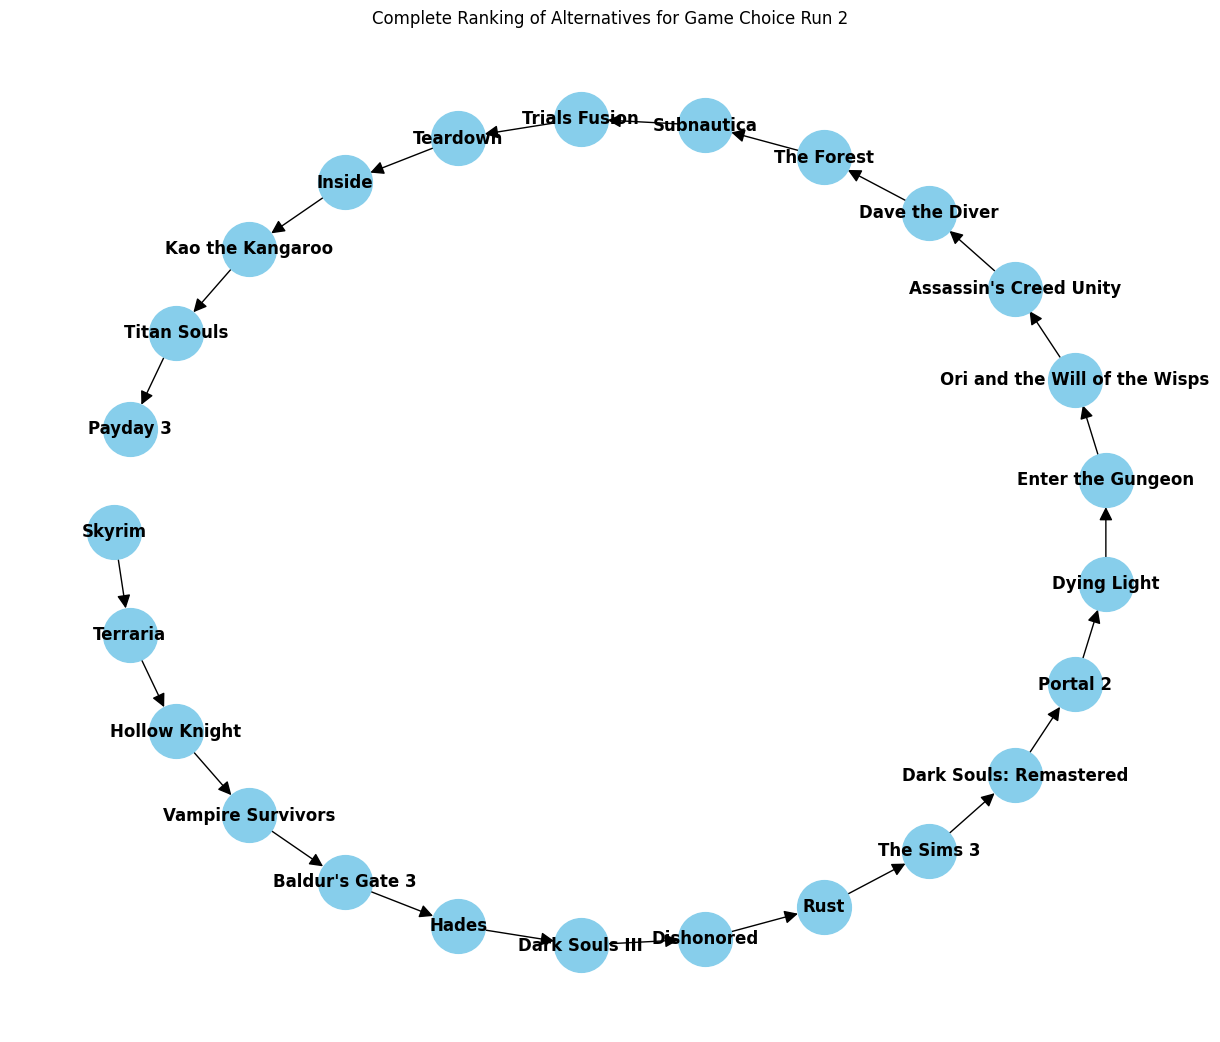

In [52]:
Image(filename='Promethee_II_results.png')

### UTA Ranking

In [53]:
ranking_uta

['Vampire_Survivors',
 'Skyrim',
 'Hollow_Knight',
 'Hades',
 "Assassin's_Creed_Unity",
 "Terraria | Baldur's_Gate_3",
 'Dark_Souls:_Remastered | Dark_Souls_III | Rust | Ori_and_the_Will_of_the_Wisps | The_Forest',
 'Portal_2 | Inside',
 'Dishonored | Dying_Light | The_Sims_3',
 'Dave_the_Diver | Teardown | Enter_the_Gungeon | Trials_Fusion | Titan_Souls',
 'Subnautica | Payday_3 | Kao_the_Kangaroo']

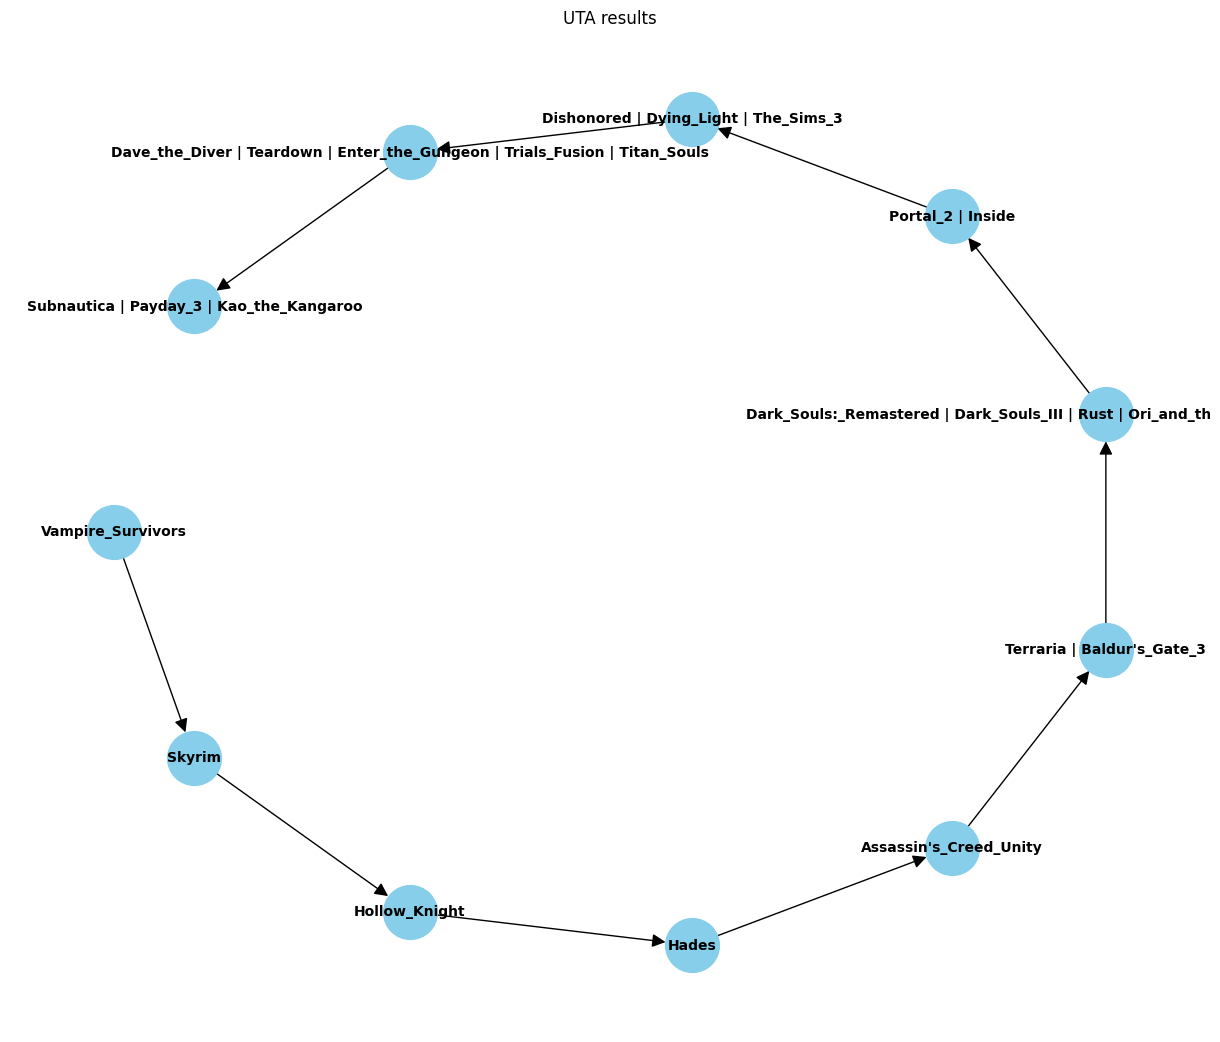

In [54]:
nodes = [item[0] for item in results_uta]

G = nx.DiGraph()
G.add_nodes_from(nodes)
for i in range(len(nodes) - 1):
    G.add_edge(nodes[i], nodes[i+1])
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight='bold', arrowsize=20)
plt.title('UTA results')
plt.show()

### AHP Ranking

In [55]:
ranking_ahp

['Vampire Survivors',
 'Terraria',
 'Skyrim',
 'Rust',
 'Dishonored',
 'The Sims 3',
 'Dying Light',
 'Hollow Knight',
 "Baldur's Gate 3",
 'Portal 2',
 "Assassin's Creed Unity",
 'Enter the Gungeon | Hades',
 'Dark Souls III',
 'Dark Souls: Remastered',
 'The Forest | Ori and the Will of the Wisps',
 'Dave the Diver',
 'Trials Fusion',
 'Inside | Titan Souls',
 'Subnautica',
 'Kao the Kangaroo',
 'Teardown',
 'Payday 3']

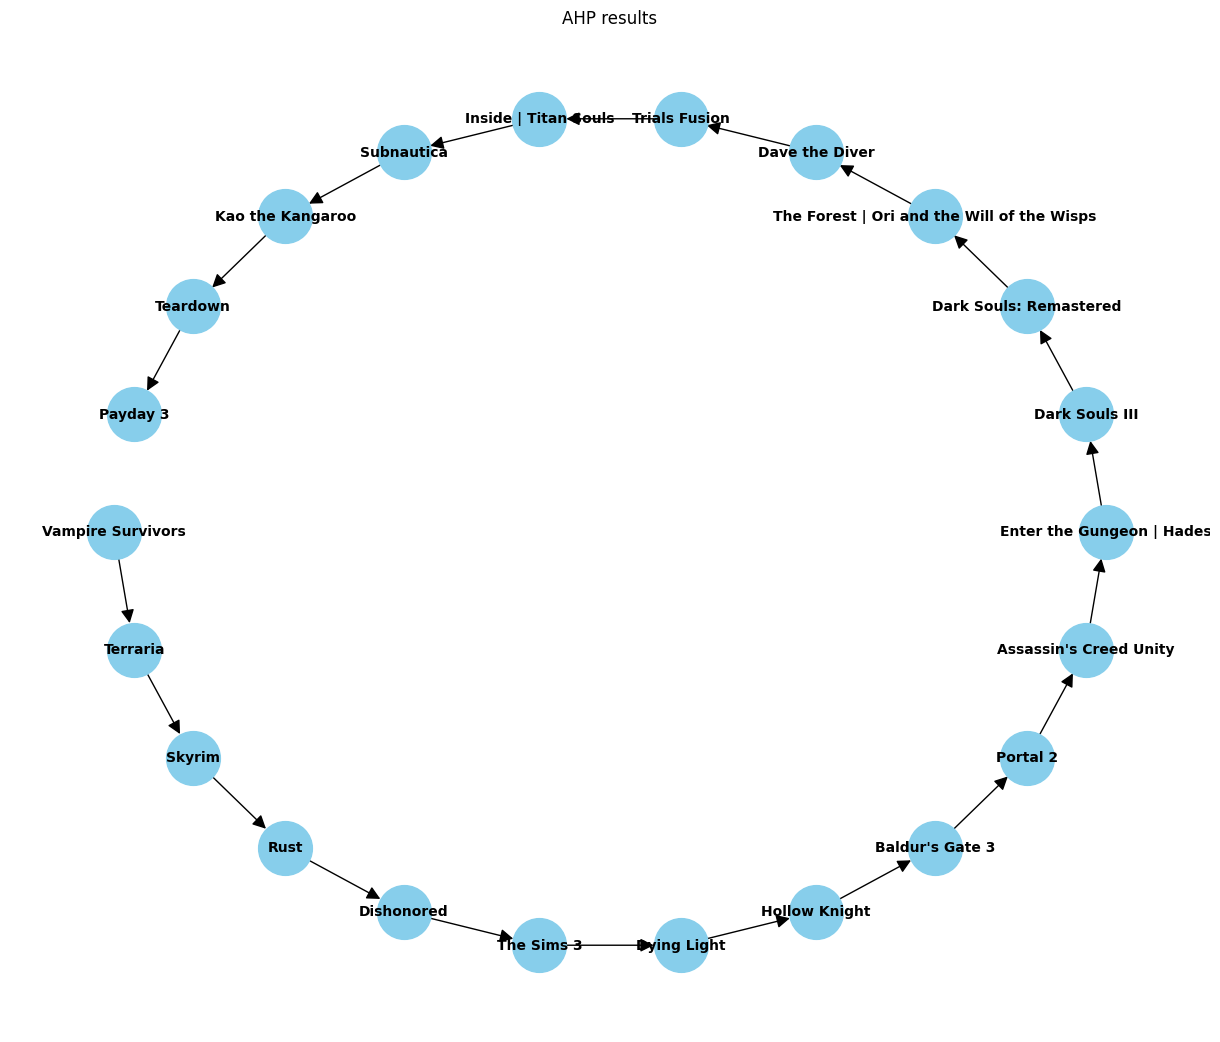

In [56]:
nodes = ranking_ahp

G = nx.DiGraph()
G.add_nodes_from(nodes)
for i in range(len(nodes) - 1):
    G.add_edge(nodes[i], nodes[i+1])
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight='bold', arrowsize=20)
plt.title('AHP results')
plt.show()

### UTA - PROMETHEE II

In [57]:
ranking_uta = refactor_ranking_list(ranking_uta)
ranking_uta

['Vampire Survivors',
 'Skyrim',
 'Hollow Knight',
 'Hades',
 "Assassin's Creed Unity",
 ['Terraria', "Baldur's Gate 3"],
 ['Dark Souls: Remastered',
  'Dark Souls III',
  'Rust',
  'Ori and the Will of the Wisps',
  'The Forest'],
 ['Portal 2', 'Inside'],
 ['Dishonored', 'Dying Light', 'The Sims 3'],
 ['Dave the Diver',
  'Teardown',
  'Enter the Gungeon',
  'Trials Fusion',
  'Titan Souls'],
 ['Subnautica', 'Payday 3', 'Kao the Kangaroo']]

In [58]:
round(get_kendall_tau(ranking_promethee2, ranking_uta), 3)

0.607

Kendall's tau: 0.607

TODO: Revise the comparison for indifferent rankings


The comparison with PROMETHEE II method reveals that although the methods differ in the top-ranking alternative, when taking into account a few of the top ranking alternatives, the values end-up being relatively similar. With the main difference being the addition of Assasin's Creed Unity towards the top, but this was probably caused by the artifical injection of it between Dark Souls Remastered and Terraria to cause the inconsistencies necessary to show the working of the algorithm in the earlier sections. Lowest-ranking alternatives also seem similar in both cases.

In general, Skyrim seems to achieve very high ranking regardless of method, which seems to have been caused by the high number of trophies, very long play-time and very good reviews from both users and critics, placing it among the favourites among all considered alternatives regardless of the exact method.
Although, it is important to mention that the UTA method for our data admitted many more indifferences than the remaining, tested methods.

In the 5 worst alternatives of both methods 3 titles are repeated, the same situation is present for the 5 best alternatives.

### UTA - AHP

In [59]:
ranking_ahp = refactor_ranking_list(ranking_ahp)

In [60]:
round(get_kendall_tau(ranking_uta, ranking_ahp), 3)

0.53

Kendall's tau: 0.53 - the worst out of the three comparisons

Although the Kendall's tau is the worst out of the comparisons, in the 5 worst classes, 5 alternatives are common. The situation is poorer in the top 5 where only 2 titles are common. Both methods chose Vampire Survivors to be the best ranked game which could be considered a good choice as the game has the highest number of achievements, lowest price and good scores on remaining criteria. 

### AHP - PROMETHEE II

In [68]:
round(get_kendall_tau(ranking_ahp, ranking_promethee2), 3)

0.717

Kendall's tau: 0.717 - the best out of the three comparisons

In the 5 worst alternative rankings of both methods 5 titles are repeated, 3 common titles are present in top 5 results of the methods. Overall, the rankings can be considered well aligned with many titles taking up similar spots and no major disagreements between the two methods.

## TESTS

TODO - delete or move to other notebook

### Kendall tau

In [ ]:
matrix1 = np.array([[0, 1, 1], [0, 0, 1], [0, 0, 0]])
# matrix2 = np.array([[0, 1, 1], [0, 0, 1], [0, 0, 0]])
matrix2 = np.array([[0, 1, 1], [0, 0, 0.5], [0, 0.5, 0]])
# matrix2 = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0]])

# get_kendall_distance(matrix1, matrix2)
1 - (4*get_kendall_distance(matrix1, matrix2) /(3*(3-1)))

In [ ]:
get_kendall_tau(["E", "B", "I"], ["I", "B", "E"])

### Priorities from quantitative values

In [ ]:
nodes = [num_of_achievements_node, price_node, length_node, genres_score_node, user_score_node, critic_score_node]
columns = ["num_of_achievements", "price", "length", "genres", "user_score", "critic_score"]

for column, node in zip(columns, nodes):
    val_sum = data[column].sum()
    priorities = data.apply(lambda x: x[column]/val_sum, axis=1)

    node.set_priorities(priorities)

In [ ]:
ahp.calculate_scores(goal_node, 1)
scores = ahp.scores.items()

In [ ]:
ranking_ahp2 = []
for score in sorted(scores, key=lambda x: x[1], reverse=True):
    name = data[data['id'] == score[0]]['name'].values[0]
    ranking_ahp2.append(name)

ranking_ahp2

In [ ]:
get_kendall_tau(ranking_promethee2, ranking_ahp2)

In [ ]:
get_kendall_tau(ranking_ahp, ranking_ahp2)

### Eigenvalues

In [ ]:
test_criteria_names = ["g21", "g22", "g23"]
test_criteria_proportions = [
    [1,   2,   5  ],
    [1/2, 1,   3  ],
    [1/5, 1/3, 1  ]
]
comparisons_test_criteria = pd.DataFrame(test_criteria_proportions, columns=test_criteria_names, index=quantity_criteria_names).to_numpy()

w, v = np.linalg.eig(comparisons_test_criteria)
w_max = w.max()
priorities = v[:,0]/v[:,0].sum()

w_max, priorities

In [ ]:
new = np.ones_like(test_criteria_proportions)
for i in range(len(priorities)):
    for j in range(len(priorities)):
        new[i,j] = priorities[i]/priorities[j]

new

In [ ]:
new[:,-1]

### Proportion based AHP

In [ ]:
comparisons_user_score = get_pairwise_proportions(data, "user_score")
comparisons_num_of_achievements = get_pairwise_proportions(data, "num_of_achievements")
comparisons_price = get_pairwise_proportions(data, "price", cost=True)
comparisons_length = get_pairwise_proportions(data, "length")
comparisons_genres_score = get_pairwise_proportions(data, "genres")
comparisons_critic_score = get_pairwise_proportions(data, "critic_score")

num_of_achievements_node = AHP_node("num_of_achievements", comparisons_num_of_achievements)
price_node = AHP_node("price", comparisons_price)
length_node = AHP_node("length", comparisons_length)
genres_score_node = AHP_node("genres", comparisons_genres_score)
user_score_node = AHP_node("user_score", comparisons_user_score)
critic_score_node = AHP_node("critic_score", comparisons_critic_score)

quality_criteria_node = AHP_node("quality", comparisons_quality_criteria,
                                 [genres_score_node, user_score_node, critic_score_node])
quantity_criteria_node = AHP_node("quantity", comparisons_quantity_criteria,
                                [num_of_achievements_node, price_node, length_node])

goal_node = AHP_node("goal", comparisons_criteria, [quantity_criteria_node, quality_criteria_node])

ahp = AHP(goal_node)

ahp.print_hierarchy()

In [ ]:
scores = ahp.solve()
scores = scores.items()

In [ ]:
ranking_ahp3 = []
for score in sorted(scores, key=lambda x: x[1], reverse=True):
    name = data[data['id'] == score[0]]['name'].values[0]
    ranking_ahp3.append(name)

ranking_ahp3

In [ ]:
get_kendall_tau(ranking_promethee2, ranking_ahp3)